# This notebook contains code by Rosemary Willatt built upon code by Robbie Mallett for processing and analysing KuKa and field data from the Polarstern ship Weddell Sea marginal ice zone cruise (PS129) in April 2022

In [1]:
from netCDF4 import Dataset
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import pickle
from scipy.stats import linregress
# import tqdm
from matplotlib.patches import Rectangle
import utils

## First, get the KuKa data and average the relevant waveforms

In [2]:
#code from Robbie to access directories he has organised

list_of_pits = pickle.load(open('../data/pit_info.p','rb'))

# data_dir# data_dir = '../data/kuka/required'
data_dir = '../data/kuka/raw/processed'


FileNotFoundError: [Errno 2] No such file or directory: '../data/pit_info.p'

In [3]:
list_of_pits

{'D1 SP1': {'dir': 'PS129_kuka',
  'code': 'D1 SP1',
  'name': 'Day 1 SP 1',
  'date': datetime.date(2022, 4, 11),
  'ku_f_names': ['kuka_stare_decon_Ku-Scat20220411-101307.nc',
   'kuka_stare_decon_Ku-Scat20220411-101807.nc'],
  'ka_f_names': ['kuka_stare_decon_Ka-Scat20220411-101306.nc',
   'kuka_stare_decon_Ka-Scat20220411-101806.nc'],
  'ka_begin': (10, 18, 7),
  'ka_end': (10, 19, 0),
  'ku_begin': (10, 13, 12),
  'ku_end': (10, 17, 40)},
 'D1 SP2': {'dir': 'PS129_kuka',
  'code': 'D1 SP2',
  'name': 'Day 1 SP 2',
  'date': datetime.date(2022, 4, 11),
  'ku_f_names': ['kuka_stare_decon_Ku-Scat20220411-112811.nc'],
  'ka_f_names': ['kuka_stare_decon_Ka-Scat20220411-112806.nc'],
  'ka_begin': (11, 30, 11),
  'ka_end': (11, 30, 52),
  'ku_begin': (11, 28, 48),
  'ku_end': (11, 29, 44)},
 'D2 SP1': {'dir': 'PS129_kuka',
  'code': 'D2 SP1',
  'name': 'Day 2 SP 1',
  'date': datetime.date(2022, 4, 16),
  'ku_f_names': ['kuka_stare_decon_Ku-Scat20220416-150102.nc',
   'kuka_stare_decon_K

In [4]:
#code by Robbie to prep data for plotting

def plot_lines(pit,
               scale='log',
               align_ka_peak=False,
               shift_ka_peak=False,
               alignment_threshold=0.07,
               xmin=0,
               xmax=6,
               normalise=False,
               r2_weighting=False,
               plot=True,
               title=True,
               pol='vv',
               data_dir='../data/kuka/required',
               ):
    
    freqranges, data_dict = utils.prepare_dicts(pit,pol,data_dir)
    all_data = utils.prepare_data(data_dict)

    argmaxs = {}
    maxs = {}
    
    return_dict = {}

    for freq in ['ku','ka']:
        
        range_diff=np.nan

        if scale == 'log':
            scan = np.log10(all_data[freq]['full_data'])
        elif scale == 'linear':
            scan = np.array(all_data[freq]['full_data'])
        else:
            raise
        
        # Times we started and stopped scanning
        
        time_begin = datetime.datetime.combine(pit['date'], datetime.time(hour=pit[f'{freq}_begin'][0],
                                                minute = pit[f'{freq}_begin'][1],
                                                second = pit[f'{freq}_begin'][2]))

        time_end = datetime.datetime.combine(pit['date'], datetime.time(hour=pit[f'{freq}_end'][0],
                                                minute = pit[f'{freq}_end'][1],
                                                second = pit[f'{freq}_end'][2]))

        # Convert times to array indexes, so we can slice the data
        
        start_index = utils.get_time_index(time_begin,
                                     all_data[freq]['times'])
        end_index = utils.get_time_index(time_end,
                                   all_data[freq]['times'])
        
        # Slice the data
        
        scan = scan[:,start_index:end_index]
        
        # Don't think this line is necessary?
#         y_tick_spacing=7

        # Average over the time slice

        line = np.mean(scan,axis=1)
        
        #if plot != 0 then plot the scan and print info
        
        if plot:
            h, ax = plt.subplots(1, 1, figsize = (4, 5))
            print(scan.shape)
            
            r1 = np.argmax(freqranges[freq] > 1)
            r3 = np.argmax(freqranges[freq] > 3)
            
#             print(freqranges[freq])

#             print('r', r1, r3)

            for i in range(scan.shape[1]):
#                 ax.plot(10*np.log10(scan[:,i]), freqranges[freq], 'grey')
#             ax.plot(10*np.log10(line), freqranges[freq])
                ax.plot(scan[r1:r3,i], freqranges[freq][r1:r3], 'grey')
            ax.plot(line[r1:r3], freqranges[freq][r1:r3], 'k', linewidth = .7)
            ax.set_xlabel('Power (linear)')
            ax.set_xlabel('Range (m)')
#             ax.text()
            ax.set_title(freq + '-band. Number of scans:' + str(scan.shape[1]))
#             ax.set_ylim(3, 1)
            plt.show()
        
        # Nan all the data outside of the range domain of interest

        line[freqranges[freq]<xmin] = np.nan
        line[freqranges[freq]>xmax] = np.nan
        
        # Option to divide by the square of the distance from the horn
        
        if r2_weighting:
            line = np.divide(line,np.square(freqranges[freq]))
        
        # This doesn't do anything anymore. To remove.
#         argmaxs[freq] = np.nanargmax(line)

        # Get max power for normalisation
        max_power = np.nanmax(line)
        
        # Create a normalised array from the power-range plot
        normline = line/abs(max_power)
        
        # Option to normalise your world
        if normalise:
            line = normline
            
        # Get the range bins
        ranges = freqranges[freq]
        
        # Raises an error if you try to auto-align and shift at same time
        if align_ka_peak and shift_ka_peak: raise
        
        # Option to align the Ka-band power-range plot with the Ku-band one.
        # This relies on Ku running before Ka, because it fills return_dict
        
        if align_ka_peak & (freq == 'ka'):
            
            # Normalise the Ku-band power (can't use the lines above, since they apply to Ka)
            
            ku_norm = return_dict['ku_values']/abs(np.nanmax(return_dict['ku_values']))
            
            # Get index of range bin where the normalised power first exceeds some threshold in each freq
            
            ku_thresh = np.argmax(ku_norm>alignment_threshold)
            ka_thresh = np.argmax(normline>alignment_threshold)
            
            # Indentify the indicies corresponding to all local maxima in the power-range plot

            ku_local_maxima = argrelextrema(ku_norm, np.greater)[0]
            ka_local_maxima = argrelextrema(normline, np.greater)[0]
            
            # Find range of nearest peak to range bin where power exceeds threshold
            
            ku_nearest_max = return_dict['ku_ranges'][ku_local_maxima[np.argmin(np.abs(ku_local_maxima-ku_thresh))]]
            ka_nearest_max = ranges[ka_local_maxima[np.argmin(np.abs(ka_local_maxima-ka_thresh))]]
            
            return_dict['ku_first_max'] = ku_nearest_max
            
            range_diff = ka_nearest_max-ku_nearest_max

#             range_diff_old = (freqranges['ka'][argmaxs['ka']]-freqranges['ku'][argmaxs['ku']])
            
            ranges = freqranges[freq] - range_diff
        
        else:
            range_diff = 0
        
        if np.array(shift_ka_peak).any() & (freq == 'ka'):
        
            range_diff = shift_ka_peak
            ranges = freqranges[freq] - range_diff
        
        return_dict[f'{freq}_ranges'] = ranges
        return_dict[f'{freq}_values'] = line
        return_dict[f'{freq}_range_diff'] = range_diff
        
    return return_dict

yticks = list(np.round(np.arange(1,0,-0.2),decimals=1)) + list(np.round(np.arange(0,1.01,0.2),decimals=1))

In [5]:
# #COMMENTING OUT AS SLOW TO RUN
# #Waveform averaging: make a latex table indicating which waveforms are averaged and plot echograms


# #plot all waveforms showing averaged ones in red rectangle
# pols = ['hh', 'hv', 'vh', 'vv']

# f, ax = plt.subplots(len(list_of_pits.values()), 8, figsize = (10, 30), 
#                      sharey = True)

# # for pit in list_of_pits.values():

# print('Pit Code', '&', 'Frequency', '&','Start index', '&','End index','&', 'Number averaged','\\'+'\\')

# for i in range(len(list_of_pits.values())):
# #     print(i)

#     pit = list(list_of_pits.values())[i]
    
# #     print(pit)

#     for freq in ['ka', 'ku']:
# #         print(freq)
        
#         if freq == 'ku':
#             budge = 4 
#         elif freq == 'ka': 
#             budge = 0

# #     print(pit)

#         for p in range(4):

#             freqranges, data_dict = utils.prepare_dicts(pit,pols[p],data_dir)
#             all_data = utils.prepare_data(data_dict)

#             nsamples = all_data[freq]['full_data'].shape[1]
            

#             ax[i,p+budge].pcolormesh(np.arange(len(all_data[freq]['time_ticks'])), 
#                            freqranges[freq], 
#                            10*np.log10(all_data[freq]['full_data']))

#             # Times we started and stopped scanning

#             time_begin = datetime.datetime.combine(pit['date'], datetime.time(hour=pit[f'{freq}_begin'][0],
#                                                     minute = pit[f'{freq}_begin'][1],
#                                                     second = pit[f'{freq}_begin'][2]))

#             time_end = datetime.datetime.combine(pit['date'], datetime.time(hour=pit[f'{freq}_end'][0],
#                                                     minute = pit[f'{freq}_end'][1],
#                                                     second = pit[f'{freq}_end'][2]))

#             # Convert times to array indexes, so we can slice the data

#             start_index = utils.get_time_index(time_begin,
#                                          all_data[freq]['times'])
#             end_index = utils.get_time_index(time_end,
#                                        all_data[freq]['times'])
            
#             ax[i,p+budge].plot([start_index, start_index],[freqranges[freq][0], freqranges[freq][-1]], 
#                        'r', linewidth = .5)
#             ax[i,p+budge].plot([end_index, end_index],[freqranges[freq][0], freqranges[freq][-1]], 
#                        'r', linewidth = .5)

#             ax[i,p+budge].set_ylim(3, 1)
    
#             if i == 0:
#                 ax[i, p+budge].set_title(freq[0].upper() + freq[1] + ' '+ pols[p].upper())
            
#         if i == 9:
#             ax[i, 0].set_ylabel('Range(m)\n' + pit['code'] )
#         else:
#             ax[i, 0].set_ylabel(pit['code'])
        
#         #make latex table of start and end index
#         print(pit['code'], '&', freq[0].upper() + freq[1], '&', start_index, 
#               '&', end_index, '&', end_index-start_index,'\\'+'\\')
        
            
# ax[i,3].set_xlabel('Waveform number')
    
# #     plt.show()

# f.savefig('../figures/averaging.jpg', dpi = 600)

{'dir': 'PS129_kuka', 'code': 'D1 SP1', 'name': 'Day 1 SP 1', 'date': datetime.date(2022, 4, 11), 'ku_f_names': ['kuka_stare_decon_Ku-Scat20220411-101307.nc', 'kuka_stare_decon_Ku-Scat20220411-101807.nc'], 'ka_f_names': ['kuka_stare_decon_Ka-Scat20220411-101306.nc', 'kuka_stare_decon_Ka-Scat20220411-101806.nc'], 'ka_begin': (10, 18, 7), 'ka_end': (10, 19, 0), 'ku_begin': (10, 13, 12), 'ku_end': (10, 17, 40)}
(2048, 577)


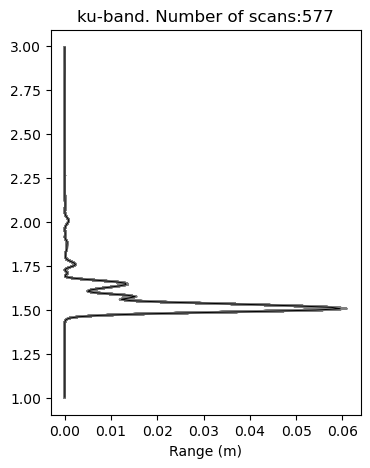

(4096, 205)


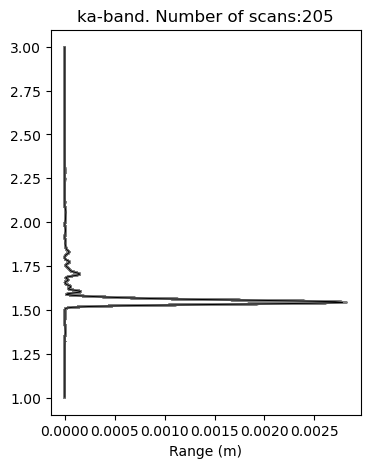

{'dir': 'PS129_kuka', 'code': 'D1 SP2', 'name': 'Day 1 SP 2', 'date': datetime.date(2022, 4, 11), 'ku_f_names': ['kuka_stare_decon_Ku-Scat20220411-112811.nc'], 'ka_f_names': ['kuka_stare_decon_Ka-Scat20220411-112806.nc'], 'ka_begin': (11, 30, 11), 'ka_end': (11, 30, 52), 'ku_begin': (11, 28, 48), 'ku_end': (11, 29, 44)}
(2048, 121)


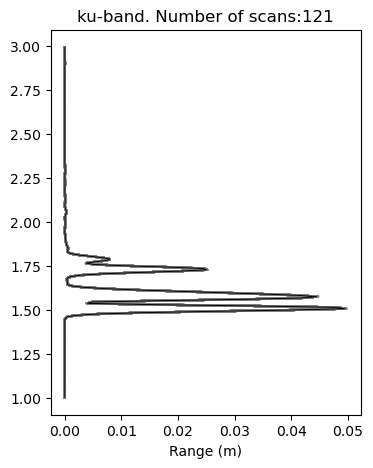

(4096, 159)


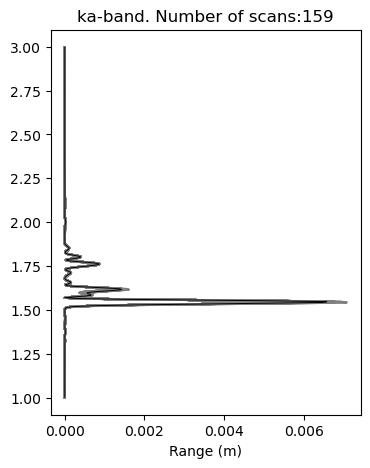

{'dir': 'PS129_kuka', 'code': 'D2 SP1', 'name': 'Day 2 SP 1', 'date': datetime.date(2022, 4, 16), 'ku_f_names': ['kuka_stare_decon_Ku-Scat20220416-150102.nc', 'kuka_stare_decon_Ku-Scat20220416-150602.nc', 'kuka_stare_decon_Ku-Scat20220416-151103.nc'], 'ka_f_names': ['kuka_stare_decon_Ka-Scat20220416-145903.nc', 'kuka_stare_decon_Ka-Scat20220416-150403.nc', 'kuka_stare_decon_Ka-Scat20220416-150903.nc'], 'ka_begin': (15, 0, 36), 'ka_end': (15, 2, 40), 'ku_begin': (15, 9, 52), 'ku_end': (15, 13, 7)}
(2048, 420)


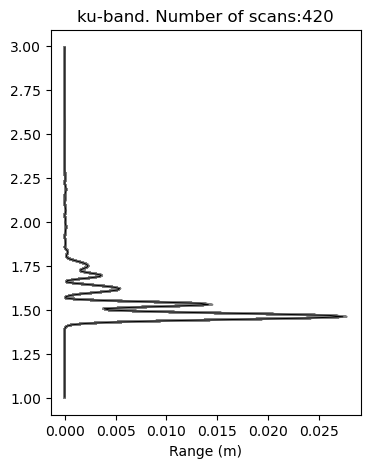

(4096, 479)


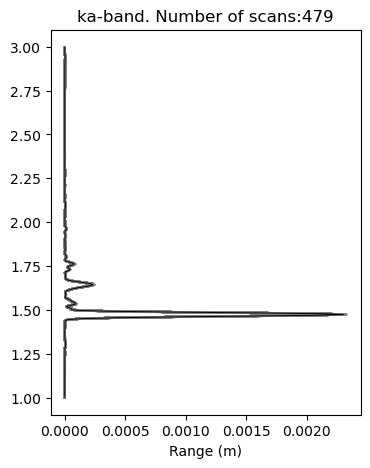

{'dir': 'PS129_kuka', 'name': 'Day 2 SP 2', 'code': 'D2 SP2', 'date': datetime.date(2022, 4, 16), 'ku_f_names': ['kuka_stare_decon_Ku-Scat20220416-162304.nc', 'kuka_stare_decon_Ku-Scat20220416-162805.nc', 'kuka_stare_decon_Ku-Scat20220416-163305.nc'], 'ka_f_names': ['kuka_stare_decon_Ka-Scat20220416-162103.nc', 'kuka_stare_decon_Ka-Scat20220416-162603.nc', 'kuka_stare_decon_Ka-Scat20220416-163103.nc', 'kuka_stare_decon_Ka-Scat20220416-163603.nc'], 'ka_begin': (16, 23, 20), 'ka_end': (16, 24, 26), 'ku_begin': (16, 29, 35), 'ku_end': (16, 30, 59)}
(2048, 181)


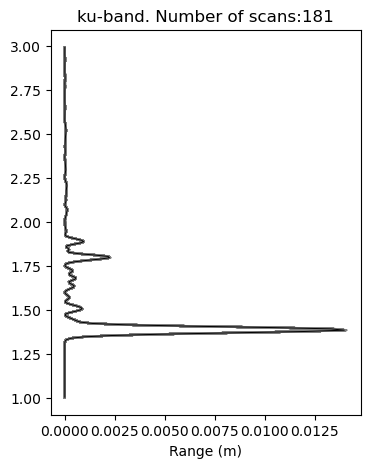

(4096, 254)


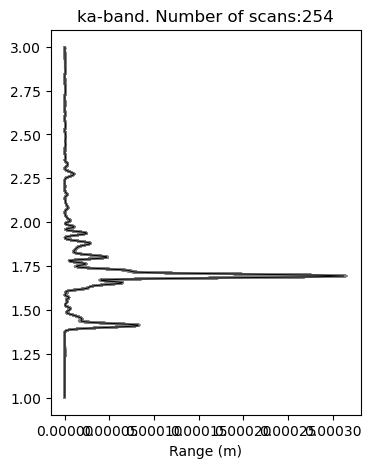

{'dir': 'PS129_kuka', 'name': 'Day 3 SP 1', 'code': 'D3 SP1', 'date': datetime.date(2022, 4, 17), 'ku_f_names': ['kuka_stare_decon_Ku-Scat20220417-132510.nc', 'kuka_stare_decon_Ku-Scat20220417-133010.nc'], 'ka_f_names': ['kuka_stare_decon_Ka-Scat20220417-132511.nc', 'kuka_stare_decon_Ka-Scat20220417-133011.nc'], 'ka_begin': (13, 25, 11), 'ka_end': (13, 29, 19), 'ku_begin': (13, 30, 7), 'ku_end': (13, 31, 59)}
(2048, 241)


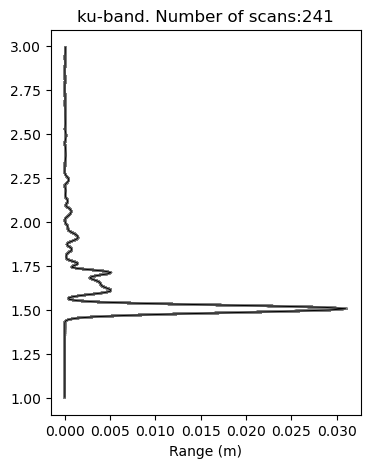

(4096, 957)


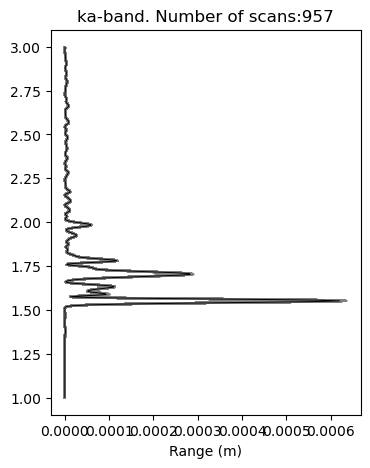

{'dir': 'PS129_kuka', 'name': 'Day 3 SP 2', 'code': 'D3 SP2', 'date': datetime.date(2022, 4, 17), 'ku_f_names': ['kuka_stare_decon_Ku-Scat20220417-142513.nc', 'kuka_stare_decon_Ku-Scat20220417-143014.nc'], 'ka_f_names': ['kuka_stare_decon_Ka-Scat20220417-142511.nc', 'kuka_stare_decon_Ka-Scat20220417-143011.nc'], 'ka_begin': (14, 26, 0), 'ka_end': (14, 28, 0), 'ku_begin': (14, 30, 11), 'ku_end': (14, 32, 0)}
(2048, 234)


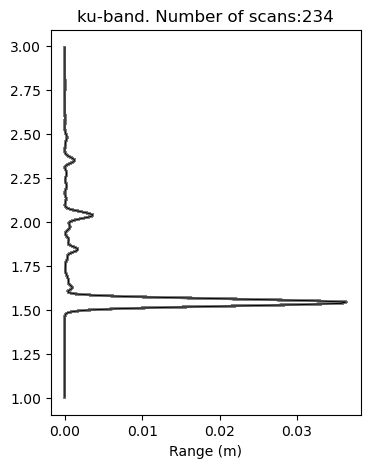

(4096, 463)


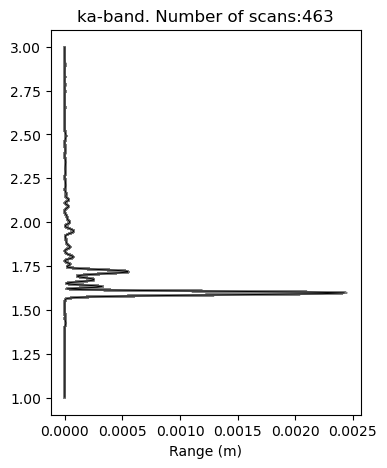

{'dir': 'PS129_kuka', 'name': 'Day 3 SP 3', 'code': 'D3 SP3', 'date': datetime.date(2022, 4, 17), 'ku_f_names': ['kuka_stare_decon_Ku-Scat20220417-151016.nc', 'kuka_stare_decon_Ku-Scat20220417-151516.nc'], 'ka_f_names': ['kuka_stare_decon_Ka-Scat20220417-151011.nc', 'kuka_stare_decon_Ka-Scat20220417-151511.nc'], 'ka_begin': (15, 14, 11), 'ka_end': (15, 16, 14), 'ku_begin': (15, 11, 55), 'ku_end': (15, 13, 45)}
(2048, 236)


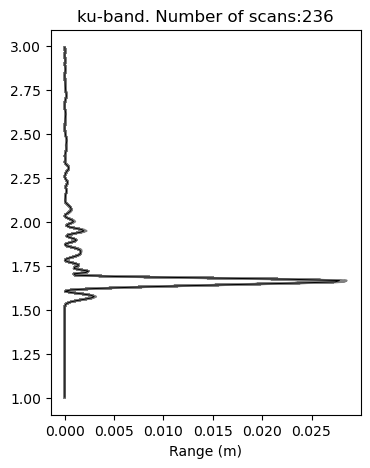

(4096, 475)


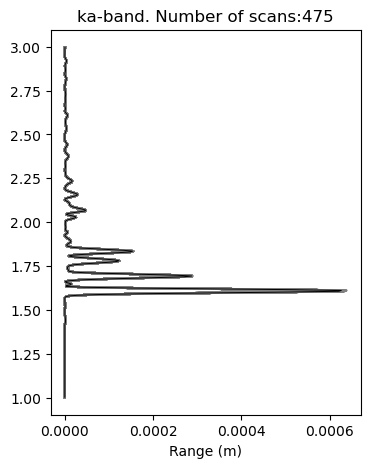

{'dir': 'PS129_kuka', 'name': 'Day 3 SP 4', 'code': 'D3 SP4', 'date': datetime.date(2022, 4, 17), 'ku_f_names': ['kuka_stare_decon_Ku-Scat20220417-154518.nc', 'kuka_stare_decon_Ku-Scat20220417-155018.nc'], 'ka_f_names': ['kuka_stare_decon_Ka-Scat20220417-154511.nc', 'kuka_stare_decon_Ka-Scat20220417-155011.nc'], 'ka_begin': (15, 45, 20), 'ka_end': (15, 46, 32), 'ku_begin': (15, 47, 47), 'ku_end': (15, 50, 15)}
(2048, 319)


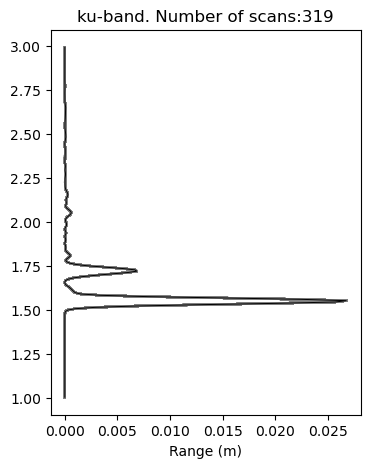

(4096, 278)


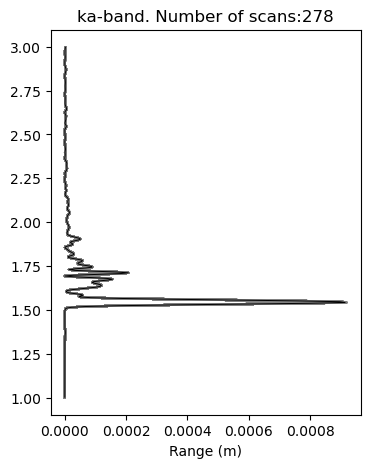

{'dir': 'PS129_kuka', 'name': 'Day 3 SP 5', 'code': 'D3 SP5', 'date': datetime.date(2022, 4, 17), 'ku_f_names': ['kuka_stare_decon_Ku-Scat20220417-161019.nc', 'kuka_stare_decon_Ku-Scat20220417-161520.nc'], 'ka_f_names': ['kuka_stare_decon_Ka-Scat20220417-161012.nc', 'kuka_stare_decon_Ka-Scat20220417-161512.nc'], 'ka_begin': (16, 12, 11), 'ka_end': (16, 13, 25), 'ku_begin': (16, 14, 2), 'ku_end': (16, 15, 17)}
(2048, 162)


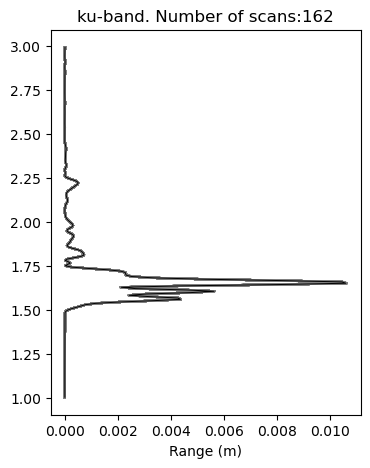

(4096, 285)


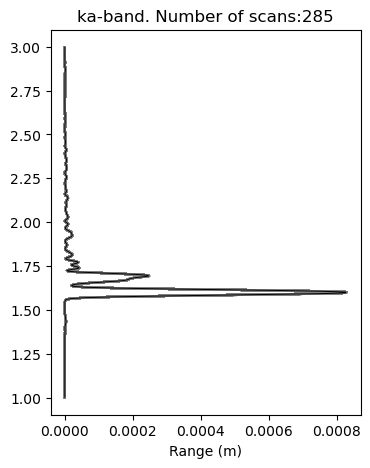

{'dir': 'PS129_kuka', 'name': 'Day 4 SP 1', 'code': 'D4 SP1', 'date': datetime.date(2022, 4, 19), 'ku_f_names': ['kuka_stare_decon_Ku-Scat20220419-133952.nc'], 'ka_f_names': ['kuka_stare_decon_Ka-Scat20220419-133951.nc'], 'ka_begin': (13, 40, 0), 'ka_end': (13, 41, 0), 'ku_begin': (13, 42, 0), 'ku_end': (13, 43, 0)}
(2048, 129)


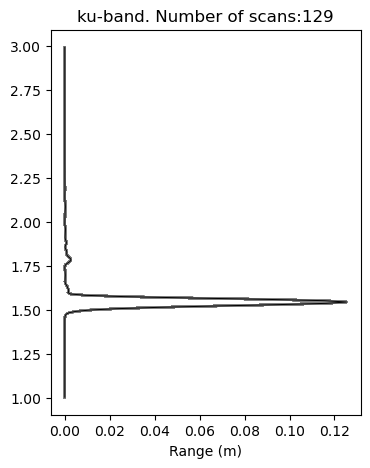

(4096, 231)


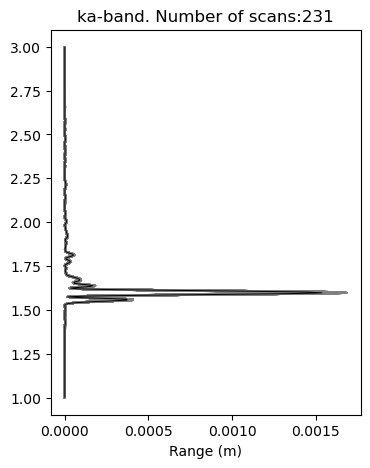

{'dir': 'PS129_kuka', 'name': 'Day 4 SP 2', 'code': 'D4 SP2', 'date': datetime.date(2022, 4, 19), 'ku_f_names': ['kuka_stare_decon_Ku-Scat20220419-140954.nc'], 'ka_f_names': ['kuka_stare_decon_Ka-Scat20220419-140951.nc'], 'ka_begin': (14, 10, 0), 'ka_end': (14, 11, 0), 'ku_begin': (14, 12, 22), 'ku_end': (14, 13, 22)}
(2048, 129)


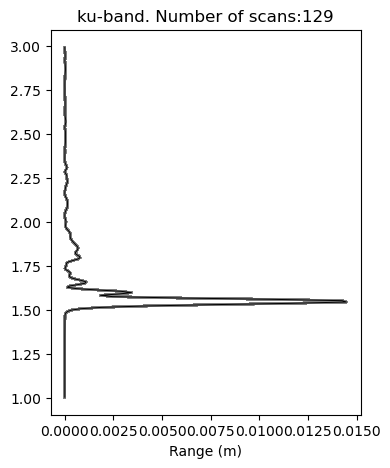

(4096, 232)


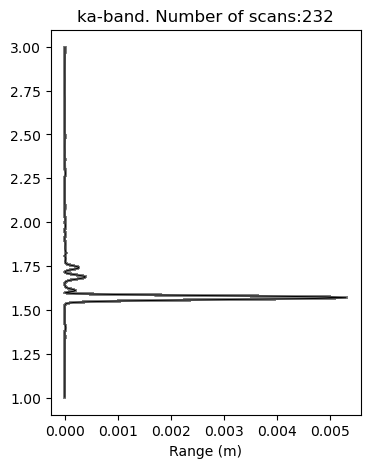

{'dir': 'PS129_kuka', 'name': 'Day 4 SP 3', 'code': 'D4 SP3', 'date': datetime.date(2022, 4, 19), 'ku_f_names': ['kuka_stare_decon_Ku-Scat20220419-145956.nc', 'kuka_stare_decon_Ku-Scat20220419-150457.nc'], 'ka_f_names': ['kuka_stare_decon_Ka-Scat20220419-145952.nc', 'kuka_stare_decon_Ka-Scat20220419-150452.nc'], 'ka_begin': (15, 4, 0), 'ka_end': (15, 5, 0), 'ku_begin': (15, 0, 0), 'ku_end': (15, 1, 0)}
(2048, 129)


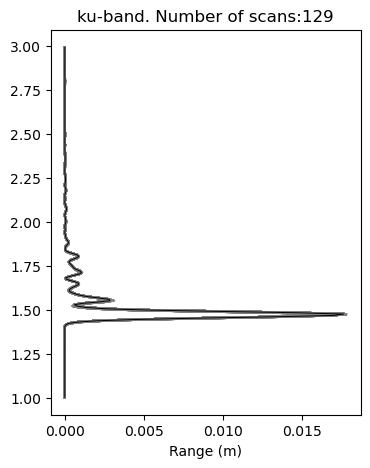

(4096, 231)


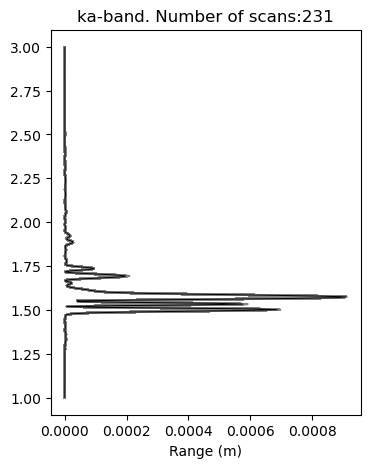

{'dir': 'PS129_kuka', 'name': 'Day 5 SP 1', 'code': 'D5 SP1', 'date': datetime.date(2022, 4, 22), 'ku_f_names': ['kuka_stare_decon_Ku-Scat20220422-144021.nc', 'kuka_stare_decon_Ku-Scat20220422-144521.nc'], 'ka_f_names': ['kuka_stare_decon_Ka-Scat20220422-144019.nc', 'kuka_stare_decon_Ka-Scat20220422-144519.nc'], 'ka_begin': (14, 42, 30), 'ka_end': (14, 43, 30), 'ku_begin': (14, 45, 0), 'ku_end': (14, 46, 0)}
(2048, 129)


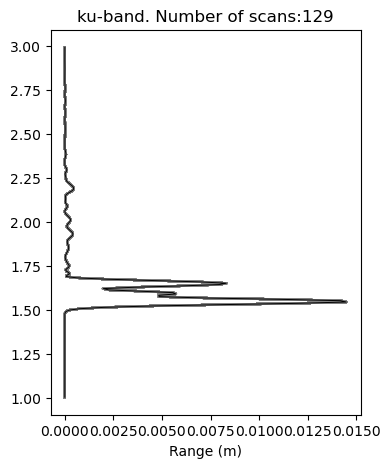

(4096, 230)


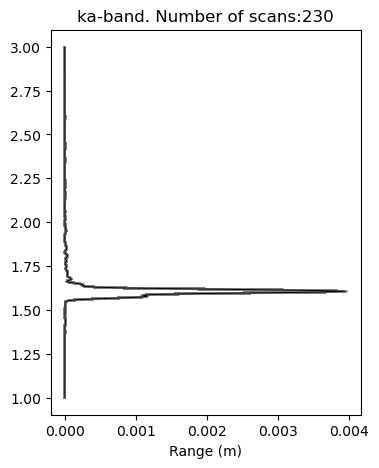

{'dir': 'PS129_kuka', 'name': 'Day 5 SP2 natural', 'code': 'D5 SP2', 'date': datetime.date(2022, 4, 22), 'ku_f_names': ['kuka_stare_decon_Ku-Scat20220422-152023.nc'], 'ka_f_names': ['kuka_stare_decon_Ka-Scat20220422-152019.nc'], 'ka_begin': (15, 20, 30), 'ka_end': (15, 21, 30), 'ku_begin': (15, 22, 0), 'ku_end': (15, 23, 0)}
(2048, 129)


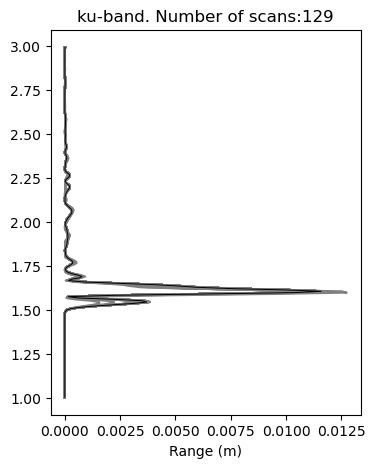

(4096, 232)


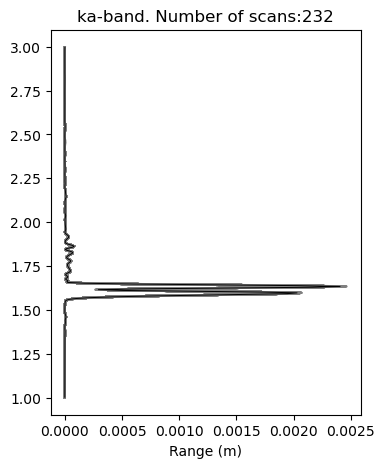

{'dir': 'PS129_kuka', 'name': 'Day 5 SP3', 'code': 'D5 SP3', 'date': datetime.date(2022, 4, 22), 'ku_f_names': ['kuka_stare_decon_Ku-Scat20220422-160526.nc', 'kuka_stare_decon_Ku-Scat20220422-161026.nc', 'kuka_stare_decon_Ku-Scat20220422-161527.nc'], 'ka_f_names': ['kuka_stare_decon_Ka-Scat20220422-160520.nc', 'kuka_stare_decon_Ka-Scat20220422-161020.nc', 'kuka_stare_decon_Ka-Scat20220422-161520.nc'], 'ka_begin': (16, 6, 0), 'ka_end': (16, 7, 0), 'ku_begin': (16, 18, 0), 'ku_end': (16, 19, 0)}
(2048, 129)


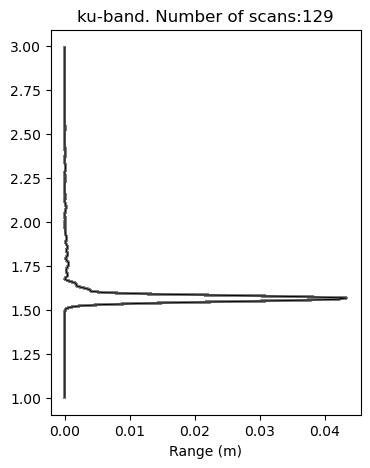

(4096, 232)


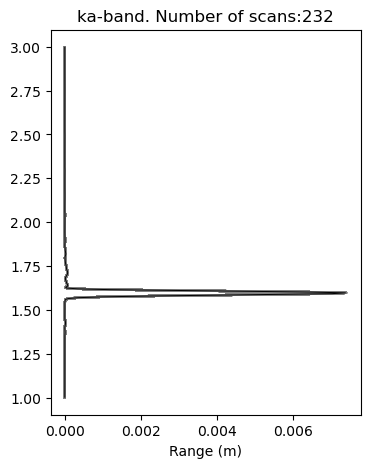

{'dir': 'PS129_kuka', 'name': 'Day 5 SP4', 'code': 'D5 SP4', 'date': datetime.date(2022, 4, 22), 'ku_f_names': ['kuka_stare_decon_Ku-Scat20220422-164028.nc'], 'ka_f_names': ['kuka_stare_decon_Ka-Scat20220422-164020.nc'], 'ka_begin': (16, 40, 21), 'ka_end': (16, 41, 1), 'ku_begin': (16, 41, 42), 'ku_end': (16, 42, 42)}
(2048, 129)


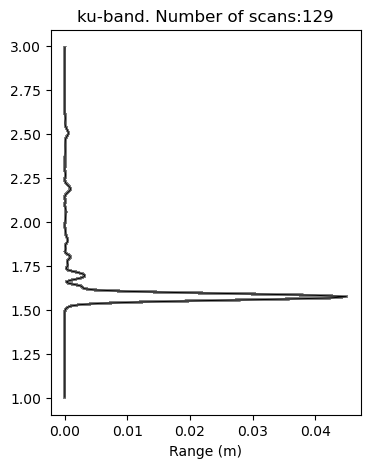

(4096, 155)


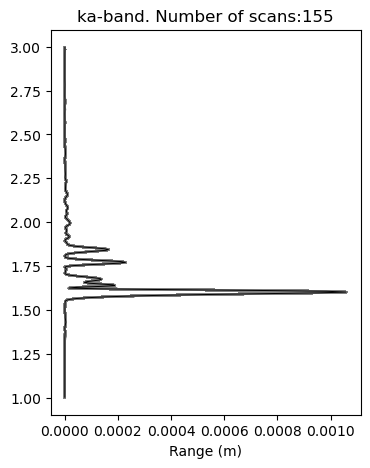

{'dir': 'PS129_kuka', 'name': 'Day 5 SP5', 'code': 'D5 SP5', 'date': datetime.date(2022, 4, 22), 'ku_f_names': ['kuka_stare_decon_Ka-Scat20220422-171020.nc', 'kuka_stare_decon_Ka-Scat20220422-171520.nc', 'kuka_stare_decon_Ka-Scat20220422-172020.nc'], 'ka_f_names': ['kuka_stare_decon_Ku-Scat20220422-171030.nc', 'kuka_stare_decon_Ku-Scat20220422-171530.nc', 'kuka_stare_decon_Ku-Scat20220422-172030.nc'], 'ku_begin': (17, 14, 31), 'ku_end': (17, 16, 7), 'ka_begin': (17, 19, 20), 'ka_end': (17, 19, 45)}
(4096, 370)


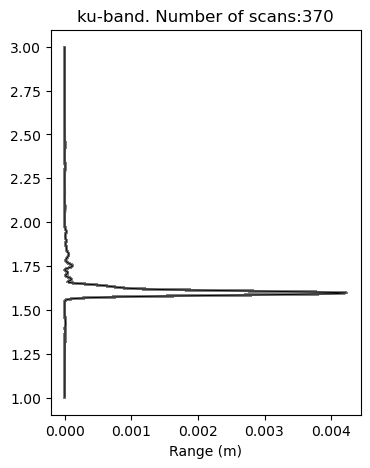

(2048, 54)


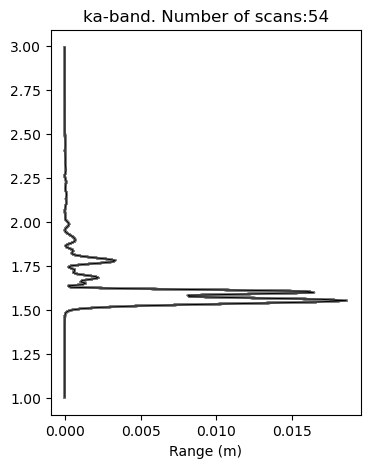

In [6]:
#check waveforms are consistent to ensure no errors in timing selection for averaging

xmin = 1
xmax = 3
for pit in list_of_pits.values():
    
    print(pit)
    
    code = pit['code']
    
    cp_vv = plot_lines(pit,scale='linear',
                xmin=xmin,
                xmax=xmax,
                normalise=False,
                align_ka_peak=True,
                pol='vv',
                r2_weighting=False,
                plot=True,
                data_dir = data_dir
                  ) 

Now shift the Ka-band waveforms to align with the Ku-band waveforms

In [7]:
#Robbie code to get waveforms, aligning ka peaks using ku vv but no other corrections

yticks = [1,0.5,0,0.5,1]

cps_vv = []
cps_hh = []
xps_hv = []
xps_vh = []
codes = []


xmax = 16 #get data up to 16 m range
xmin = 0 #get data from 0 m range
    
for pit in list_of_pits.values():
        
    code = pit['code']
    
    cp_vv = plot_lines(pit,scale='linear',
                xmin=xmin,
                xmax=xmax,
                normalise=False,
                align_ka_peak=True,
                pol='vv',
                r2_weighting=False,
                plot=False,
                data_dir = data_dir
                  ) 
    
    print(code, 'ka_range_diff', cp_vv['ka_range_diff'])
    
    cp_hh = plot_lines(pit,scale='linear',
                xmin=xmin,
                xmax=xmax,
                normalise=False,
                shift_ka_peak=cp_vv['ka_range_diff'],
                pol='hh',
#                 r2_weighting=False,
                plot=False,
                data_dir = data_dir
                  ) 

    xp_hv = plot_lines(pit,scale='linear',
                xmin=xmin,
                xmax=xmax,
                normalise=False,
                shift_ka_peak=cp_vv['ka_range_diff'],
                pol='hv',
                r2_weighting=False,
                plot=False,
                data_dir = data_dir
                    )   
    xp_vh = plot_lines(pit,scale='linear',
                xmin=xmin,
                xmax=xmax,
                normalise=False,
                shift_ka_peak=cp_vv['ka_range_diff'],
                pol='vh',
                r2_weighting=False,
                plot=False,
                data_dir = data_dir
                    )   


    cps_vv.append(cp_vv)
    cps_hh.append(cp_hh)
    
    xps_hv.append(xp_hv)
    xps_vh.append(xp_vh)
    
    codes.append(code)


D1 SP1 ka_range_diff 0.036022949218750266
D1 SP2 ka_range_diff 0.040600585937500266
D2 SP1 ka_range_diff 0.013134765625000266
D2 SP2 ka_range_diff 0.025341796875000266
D3 SP1 ka_range_diff 0.045178222656250266
D3 SP2 ka_range_diff 0.052807617187500266
D3 SP3 ka_range_diff 0.036022949218750266
D3 SP4 ka_range_diff -0.009753417968749734
D3 SP5 ka_range_diff 0.042126464843750266
D4 SP1 ka_range_diff 0.011608886718750266
D4 SP2 ka_range_diff 0.025341796875000266
D4 SP3 ka_range_diff 0.025341796875000266
D5 SP1 ka_range_diff 0.034497070312500266
D5 SP2 ka_range_diff 0.052807617187500266
D5 SP3 ka_range_diff 0.029919433593750266
D5 SP4 ka_range_diff 0.026867675781250266
D5 SP5 ka_range_diff -0.045178222656250266


In [8]:
#make dictionary containing the KuKa data

data = {'hh': cps_hh,
        'vv': cps_vv,
        'hv': xps_hv,
        'vh': xps_vh,
        'code': codes}

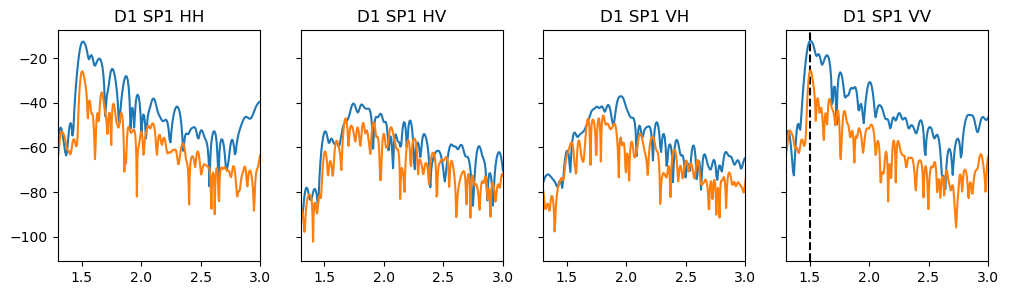

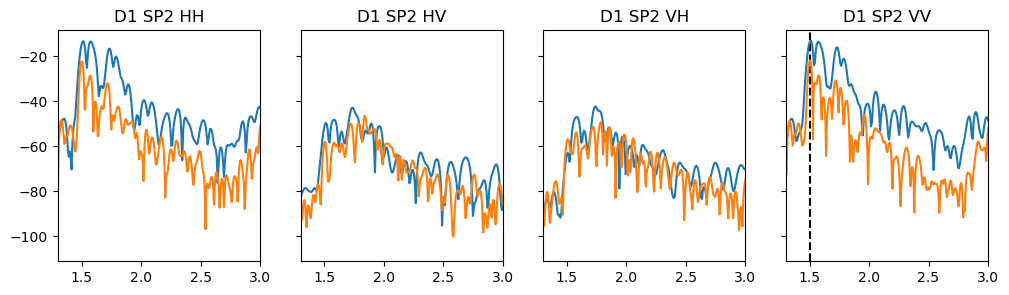

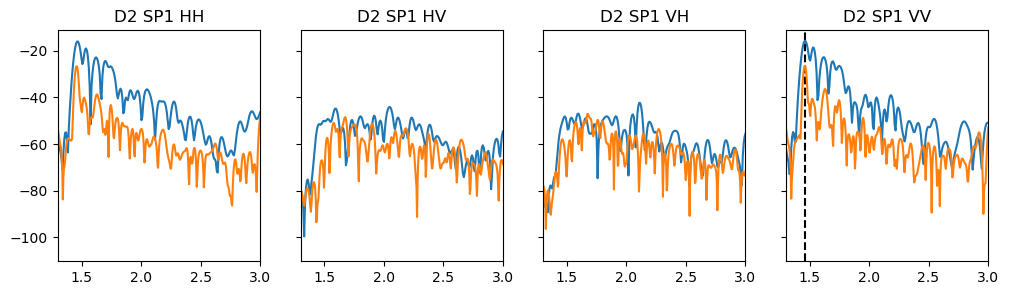

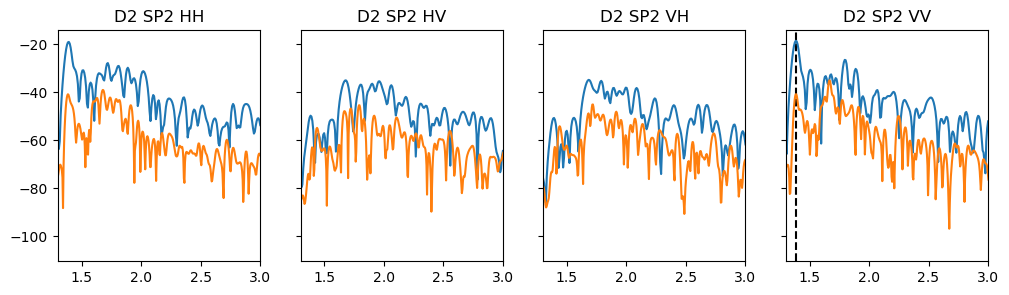

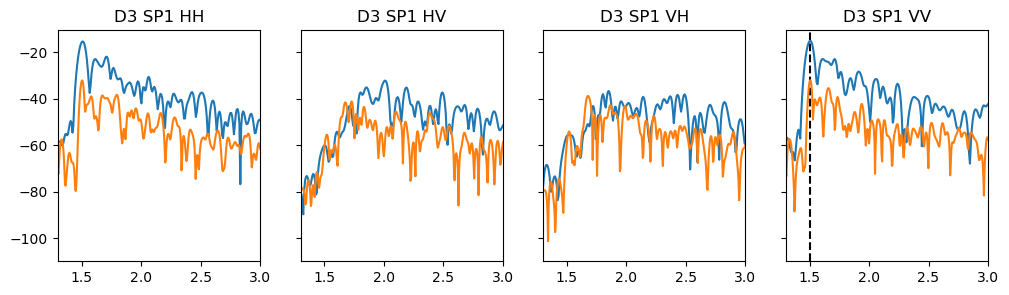

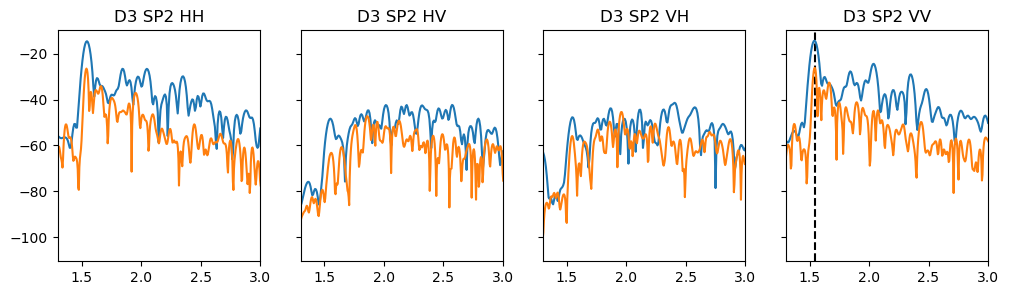

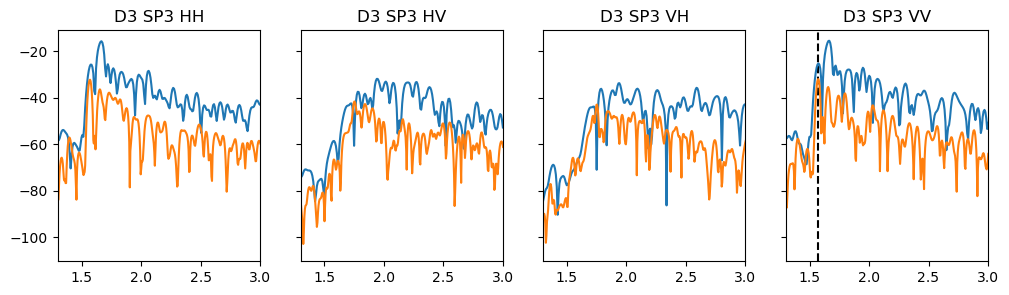

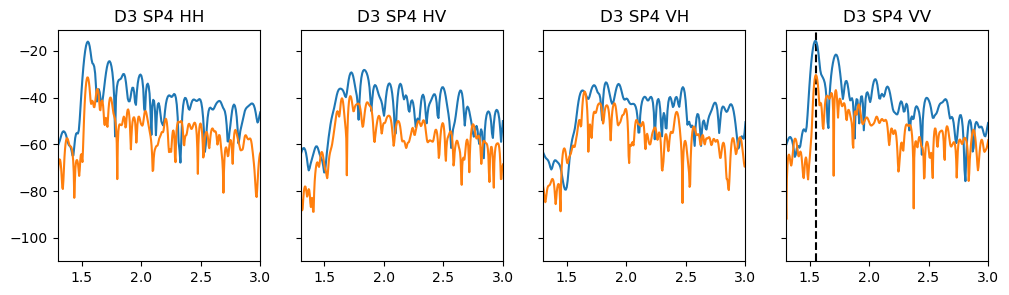

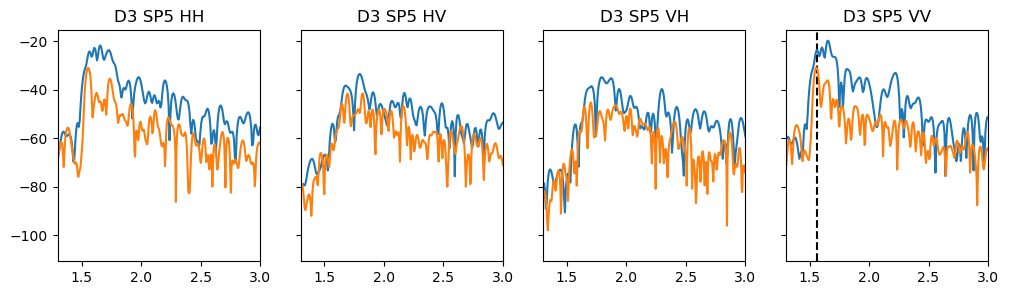

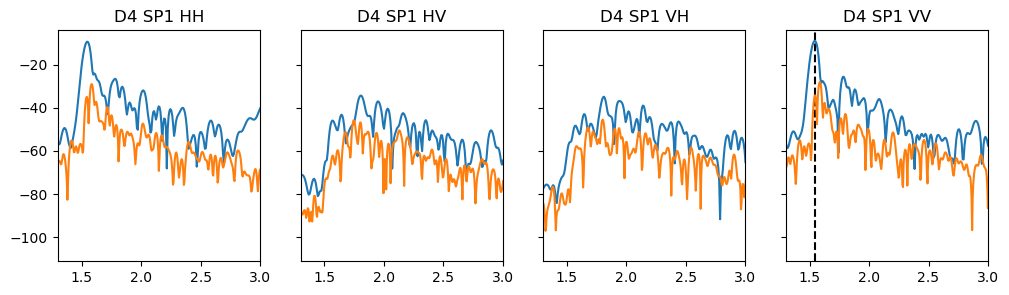

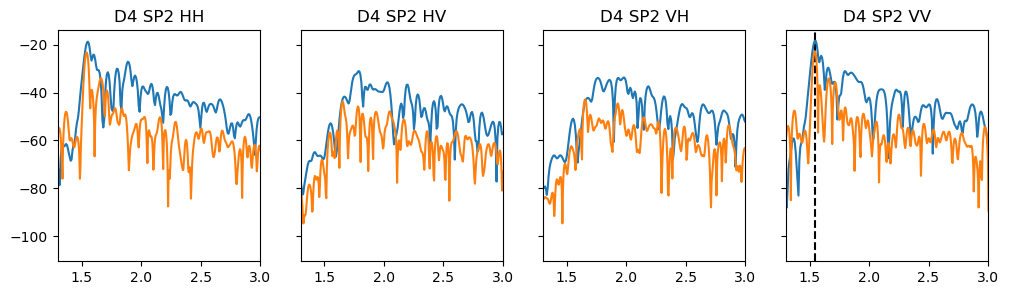

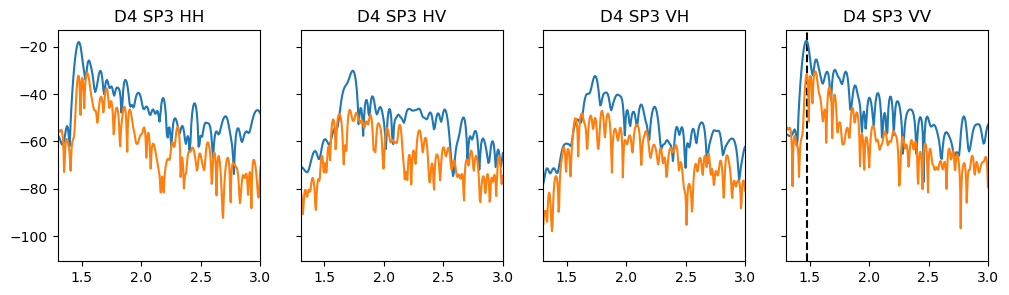

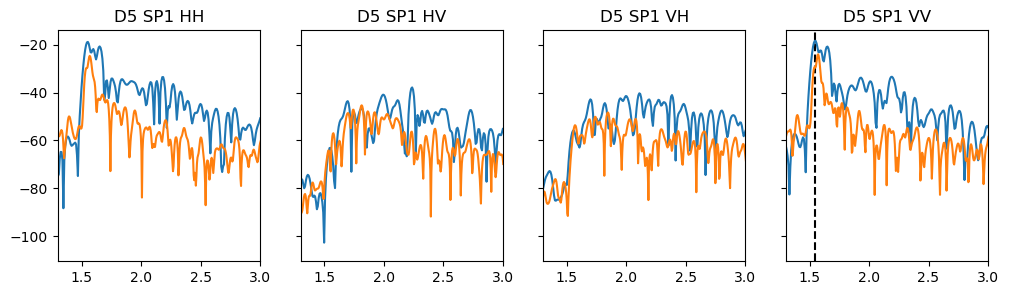

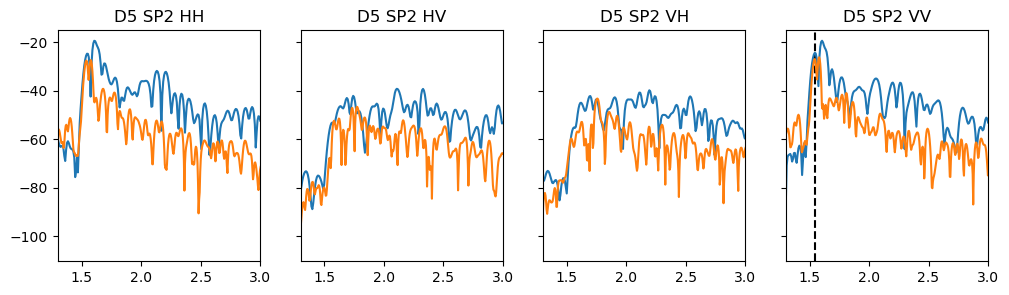

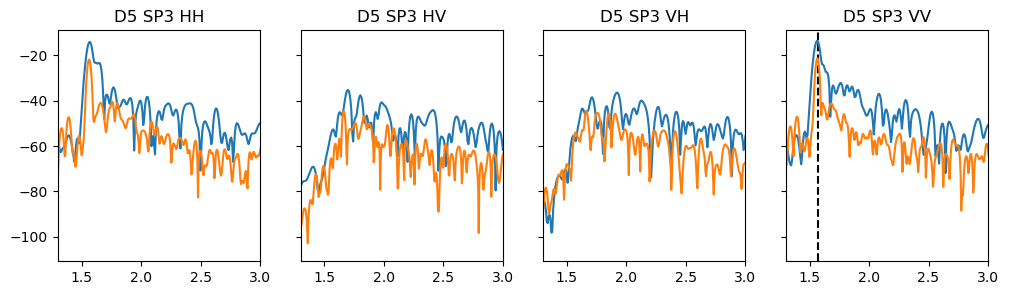

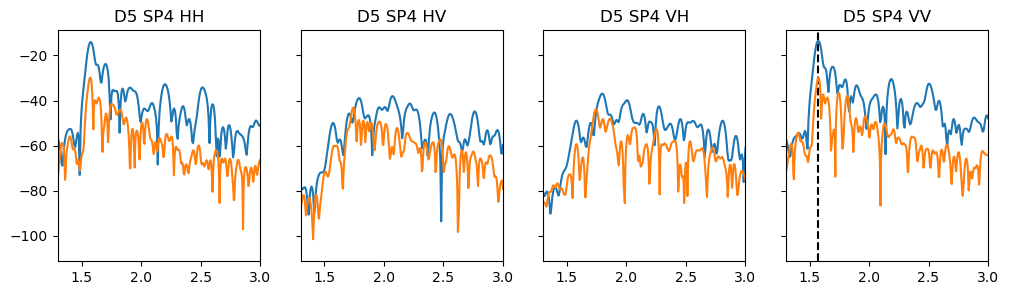

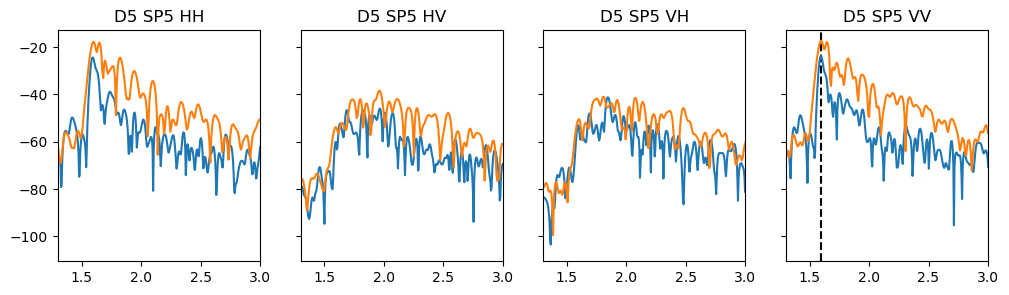

In [9]:
#check the aligning code has worked correctly

pols = ['hh', 'hv', 'vh', 'vv']

for i in range(17):
    f, ax = plt.subplots(1,4, figsize = (12, 3), sharey = True)

    for j in range(4):
        
        if pols[j] == 'vv':ax[j].axvline(data[pols[j]][i]['ku_first_max'],ls='--',color='k')
            
        ax[j].plot(data[pols[j]][i]['ku_ranges'], 10*np.log10(data[pols[j]][i]['ku_values']))
        ax[j].plot(data[pols[j]][i]['ka_ranges'], 10*np.log10(data[pols[j]][i]['ka_values']))
        ax[j].set_title(data['code'][i] + ' ' + pols[j].upper())
        ax[j].set_xlim(1.3,3)
    plt.show()


Now get the snow data (depths and densities)

In [10]:
#read in snow pit info from csv file
rr2r_df = pd.read_csv('../data/geophys/snowpits_depths.csv')
rr2r_df

Pit Code  Day Number  Pit Number Old Snow Depth  New Snow Depth  \
0    D1 SP1         1.0         1.0             18       12.000000   
1    D1 SP2         1.0         2.0             10       18.000000   
2    D2 SP1         2.0         1.0             43       10.000000   
3    D2 SP2         2.0         2.0            NaN       20.500000   
4    D3 SP1         3.0         1.0             62        8.000000   
5    D3 SP2         3.0         2.0             55       15.000000   
6    D3 SP3         3.0         3.0             64        7.000000   
7    D3 SP4         3.0         4.0             50        1.000000   
8    D3 SP5         3.0         5.0        Unknown        6.500000   
9    D4 SP1         4.0         1.0             21        9.000000   
10   D4 SP2         4.0         2.0             24        6.500000   
11   D4 SP3         4.0         3.0             11       15.000000   
12   D5 SP1         5.0         1.0        Unknown       13.000000   
13   D5 SP2         5.0         2.0             49        9.000000   
14   D5 SP3         5.0         3.0             48        5.500000   
15   D5 SP4         5.0         4.0             42       13.000000   
16   D5 SP5         5.0         5.0        Unknown       10.500000   
17      NaN         NaN         NaN    38.23076923       10.558824   
18      NaN         NaN         NaN    38.23076923       10.558824   
19      NaN         NaN         NaN            NaN             NaN   
20      NaN         NaN         NaN            NaN             NaN   
21      NaN         NaN         NaN            NaN             NaN   
22      NaN         NaN         NaN            NaN             NaN   
23      NaN         NaN         NaN            NaN             NaN   
24      NaN         NaN         NaN            NaN             NaN   
25      NaN         NaN         NaN            NaN      387.200000   

    Total Depth                                              Notes  \
0            30                                           No photo   
1            28                             Dug to sea ice surface   
2            53                                                NaN   
3          20.5      No old snow at this site, it was on a hummock   
4            70                                                NaN   
5            70                                                NaN   
6            71                                                NaN   
7            51                                                NaN   
8       Unknown                                                NaN   
9            30                                                NaN   
10         30.5                                                NaN   
11           26      Initially failed to drill with 1”, then cored   
12      Unknown                                                NaN   
13           58  Roughness experiment + ~48cm core with icy bot...   
14         53.5  Uniform looking snow, core with icy bottom thi...   
15           55   Deposited patch, core with frosty head recovered   
16      Unknown                          Snow clearance experiment   
17  46.17857143                                            #DIV/0!   
18  46.17857143                                                NaN   
19          NaN                                                NaN   
20          NaN                                                NaN   
21          NaN                                                NaN   
22          NaN                                                NaN   
23          NaN                                                NaN   
24          NaN                                                NaN   
25          NaN                                                NaN   

                                   Snow Density Above Snow Density Below  \
0                                                 212                504   
1                                                 266                

In [11]:
#make latex table of snow depths and densities for each pit and mean values

to_include = ['Code', 
#               'Day', 'Pit', 
              'Remnant Depth (cm)', 'New Depth (cm)', 'Total Depth', 
              'New Density (g/cm^3)', 'Remnant Density (g/cm^3)']

s1 = ''
for i in to_include:
    s1 += i + '&'

s1 = s1[:-2] + '\\' + '\\'
print(s1)

for j in range(0, 17):
    
    line = np.array(rr2r_df.iloc[j])
    s2 = ''
    
    for k in [0,3,4,5,7,8]:
        
        if ((k == 1) | (k == 2)):
            add =  str(line[k].astype(int))
        if (str(line[k]) == 'Could not sample') | (str(line[k]) == 'nan'):
            add = 'N/A' 
        else:
            add = str(line[k])
        s2 += add + '&'
        
    s2 = s2[:-1] + '\\'+ '\\'
    print(s2)
    
#add the mean values
ok = np.where(np.array(rr2r_df['Total Depth'][0:17]) != 'Unknown')[0]

nd = np.array(rr2r_df['New Snow Depth'][ok].astype(float))
ndm = round(np.nanmean(nd), 1)

od = np.array(rr2r_df['Old Snow Depth'][ok].astype(float))
odm = round(np.nanmean(od), 1)

td = np.array(rr2r_df['Total Depth'][ok].astype(float))
tdm = round(np.nanmean(td), 1)

nde = np.array(rr2r_df['Snow Density Above'][ok].astype(float))
ndem = round(np.nanmean(nde))

ode1 = rr2r_df['Snow Density Below'][ok]
ode1[ode1 == 'Could not sample'] = 'NaN'
ode = np.array(ode1.astype(float))
odem = round(np.nanmean(ode))

print('Mean&', odm, '&', ndm, '&', tdm, '&', ndem, '&', odem, '\\' + '\\')

Code&Remnant Depth (cm)&New Depth (cm)&Total Depth&New Density (g/cm^3)&Remnant Density (g/cm^3\\
D1 SP1&18&12.0&30&212&504\\
D1 SP2&10&18.0&28&266&402\\
D2 SP1&43&10.0&53&208&424\\
D2 SP2&N/A&20.5&20.5&356&N/A\\
D3 SP1&62&8.0&70&216&N/A\\
D3 SP2&55&15.0&70&248&N/A\\
D3 SP3&64&7.0&71&376&N/A\\
D3 SP4&50&1.0&51&N/A&N/A\\
D3 SP5&Unknown&6.5&Unknown&316&N/A\\
D4 SP1&21&9.0&30&232&N/A\\
D4 SP2&24&6.5&30.5&288&440\\
D4 SP3&11&15.0&26&248&N/A\\
D5 SP1&Unknown&13.0&Unknown&310&N/A\\
D5 SP2&49&9.0&58&292&N/A\\
D5 SP3&48&5.5&53.5&300&N/A\\
D5 SP4&42&13.0&55&333&N/A\\
D5 SP5&Unknown&10.5&Unknown&274&N/A\\
Mean& 38.2 & 10.7 & 46.2 & 275 & 442 \\


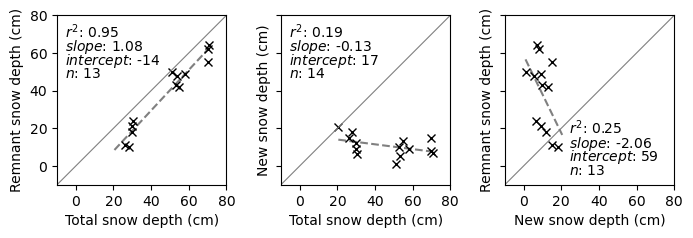

In [12]:
#plot new and old vs total snow depths

lim = [-10, 80]

f, ax = plt.subplots(1, 3, figsize = (8., 2.2), sharex = True, sharey = True)
f.subplots_adjust(wspace = .3)

xs = [td, td, nd]
xlabels = ['Total snow depth (cm)', 'Total snow depth (cm)', 'New snow depth (cm)']
ys = [od, nd, od]
ylabels = ['Remnant snow depth (cm)', 'New snow depth (cm)', 'Remnant snow depth (cm)']

for i in range(3):
    x = xs[i]
    y = ys[i]
    ok = np.where((x == x) & (y == y))[0]
    slope, intercept, r_value, p_value, std_err = linregress(x[ok], y[ok])
    line_xs = np.array([min(x), max(x)])
    line_ys = slope*line_xs + intercept
    ax[i].plot(line_xs, line_ys,  'grey', linestyle = '--')
    ax[i].plot(x, y, 'kx')
    ax[i].set_xlabel(xlabels[i])
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_aspect('equal')
    ax[i].set_xticks([0, 20, 40, 60, 80])
    ax[i].set_xlim(lim)
    ax[i].set_ylim(lim)
    ax[i].plot(lim, lim, 'grey', linewidth = .8)
    x_pos = 0.05 if (i == 0) | (i == 1) else .38
    y_pos = 0.87 if (i == 0) | (i == 1) else .3
    y_gap = .08
    ax[i].text(x_pos, y_pos, '$r^2$: ' + str(round(r_value**2, 2)), 
                         transform=ax[i].transAxes)
    ax[i].text(x_pos, y_pos - y_gap, '$slope$: ' + str(round(slope, 2)), 
                         transform=ax[i].transAxes)
    ax[i].text(x_pos, y_pos - y_gap*2, '$intercept$: ' + str(round(intercept)), 
                         transform=ax[i].transAxes)
    ax[i].text(x_pos, y_pos - y_gap*3, '$n$: ' + str(len(ok)), transform=ax[i].transAxes)

f.savefig('../figures/measured_snow_depth_scatters_new_new.jpg',  
                    bbox_inches = 'tight', dpi = 300)

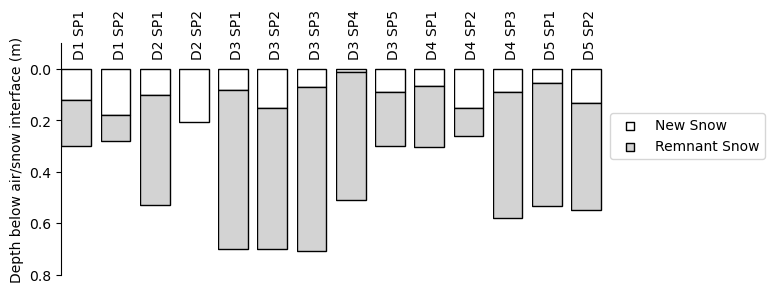

In [13]:
#plot the old and new snow depths for each snow pit

#set up plot
f, ax = plt.subplots(1, 14, figsize = (7,3))#, sharey = True)
ymax = .8
ymin = -.1
ax[0].set_ylabel('Depth below air/snow interface (m)')

#plot depths
for i in range(14):


    ax[i].add_patch(Rectangle((0, 0), 1, nd[i]/100, facecolor = 'white', edgecolor = 'black', fill=True))
    if od[i] == od[i]:
        ax[i].add_patch(Rectangle((0, nd[i]/100), 1, od[i]/100, facecolor = 'lightgrey', edgecolor = 'black', fill=True))
    ax[i].text(.4, -0.05, rr2r_df['Pit Code'][i], rotation = 90)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    if i != 0:
        ax[i].spines['left'].set_visible(False) 
        ax[i].set_yticks([-2, 2])
        ax[i].set_yticklabels([' ', ' '])

    ax[i].set_xticks([-2, 2])
    ax[i].set_xlim([0,1.1])
    ax[i].set_ylim([ymax,ymin])
    
ax[13].scatter(0, ymax + .1, s = 30, marker = 's', color = 'white', edgecolor = 'k', label = 'New Snow')
ax[13].scatter(0, ymax + .1, s = 30, marker = 's', color = 'lightgrey', edgecolor = 'k', label = 'Remnant Snow')
ax[13].legend(loc = (1.2, .5))


In [14]:
#calculate the mean bulk density for the five snow pits where 
#depths and densitities of old and new snow are known

full = [0, 1, 2, 3, 10]

nden = np.array(rr2r_df['Snow Density Above'])[full].astype(float)
ndep = np.array(rr2r_df['New Snow Depth'])[full].astype(float)

oden = np.array(rr2r_df['Snow Density Below'])[full].astype(float)
odep = np.array(rr2r_df['Old Snow Depth'])[full].astype(float)

tdep = np.array(rr2r_df['Total Depth'])[full].astype(float)

name = np.array(rr2r_df['Pit Code'])[full]
index = np.where(name == 'D2 SP2')[0]

if len(index) > 0:
    odep[index] = 0
    oden[index] = 0
    
bulk_dens = (np.divide((np.multiply(ndep, nden) + np.multiply(odep, oden)), tdep))

[print(name[i], round(bulk_dens[i])) for i in range(len(full))]

mean_bulk_dens = np.mean(bulk_dens)

print('mean bulk density: ', round(mean_bulk_dens))

D1 SP1 387
D1 SP2 315
D2 SP1 383
D2 SP2 356
D4 SP2 408
mean bulk density:  370


Now, make the layerwise adjustments to the waveforms and adjust for the spreading of the transmitted radiation
Make plots showing these adjustments and plot all adjusted waveforms for both frequencies and all polarisations

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
/var/folders/hk/9x_1xq796d3gfx82y401_v_h0000gn/T/ipykernel_37391/1039718684.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close(

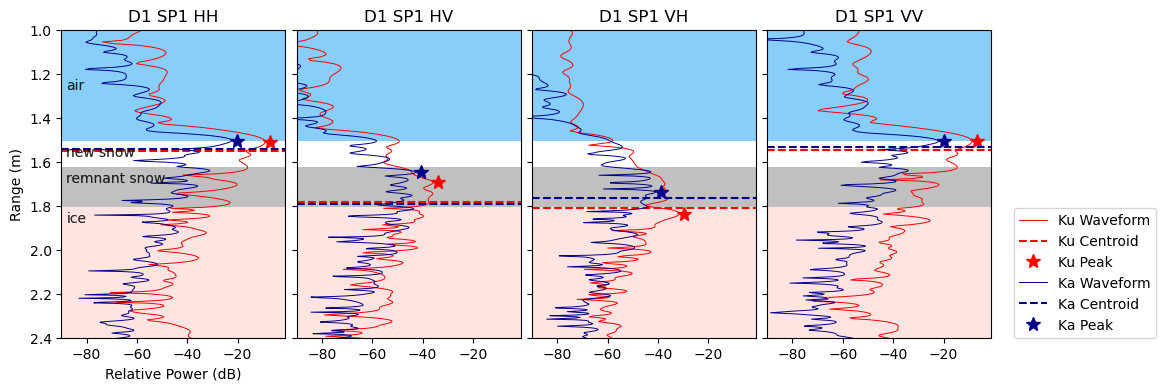

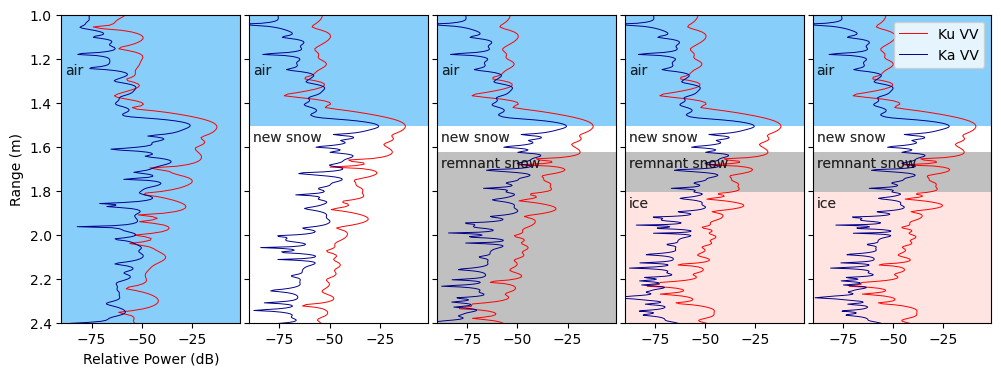

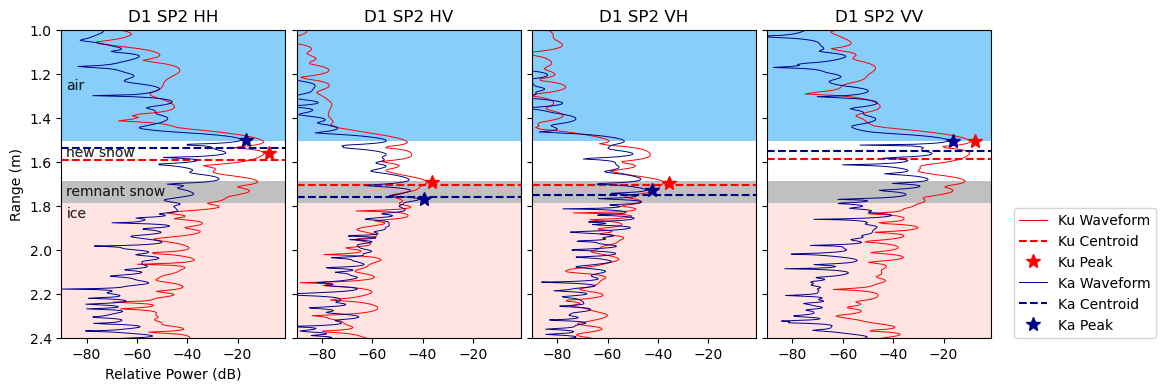

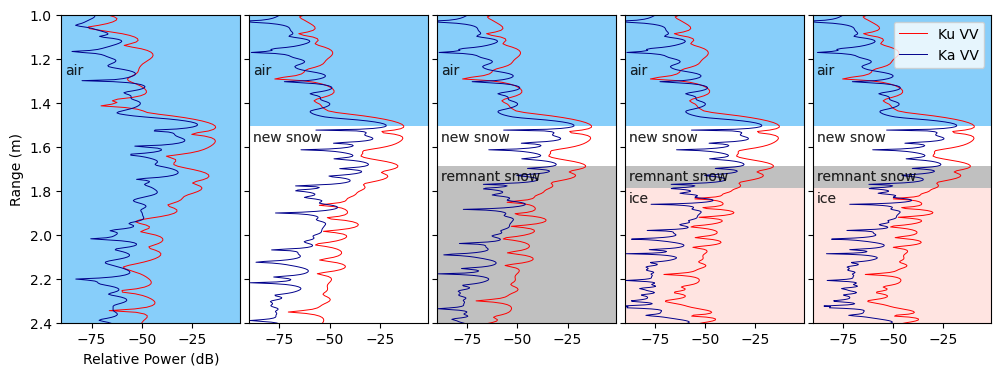

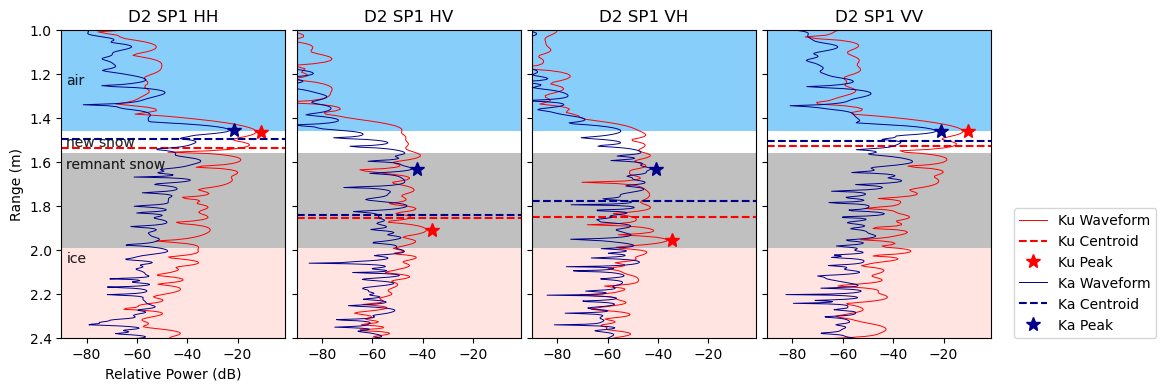

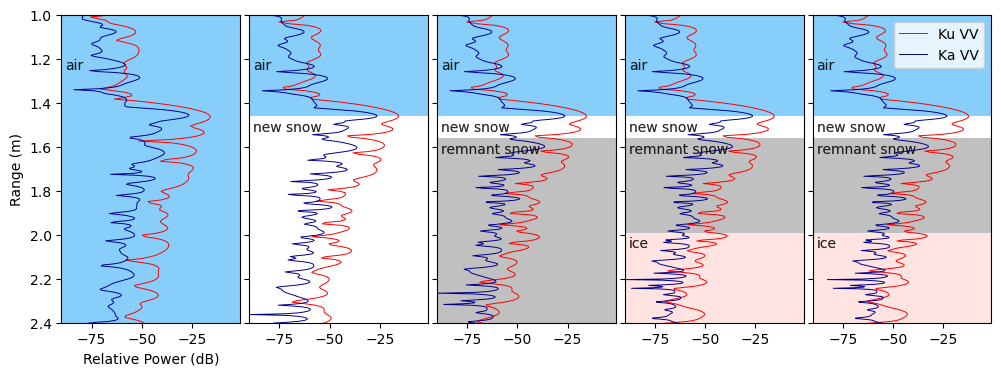

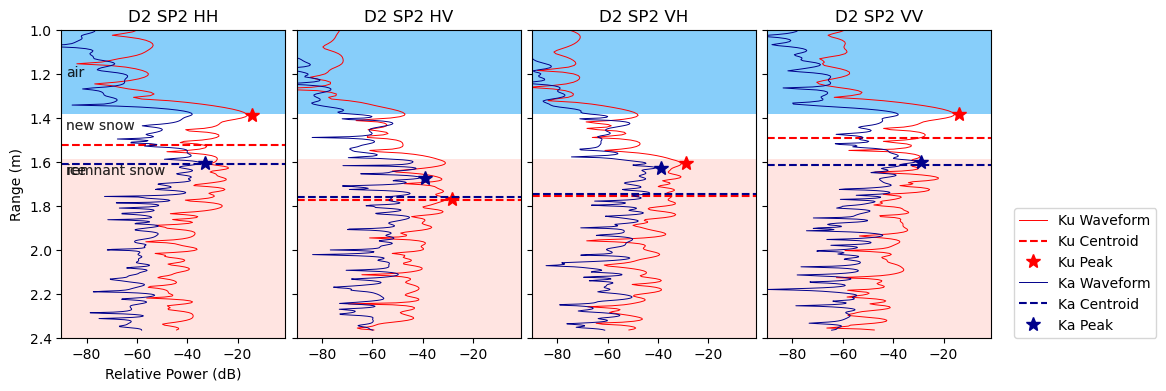

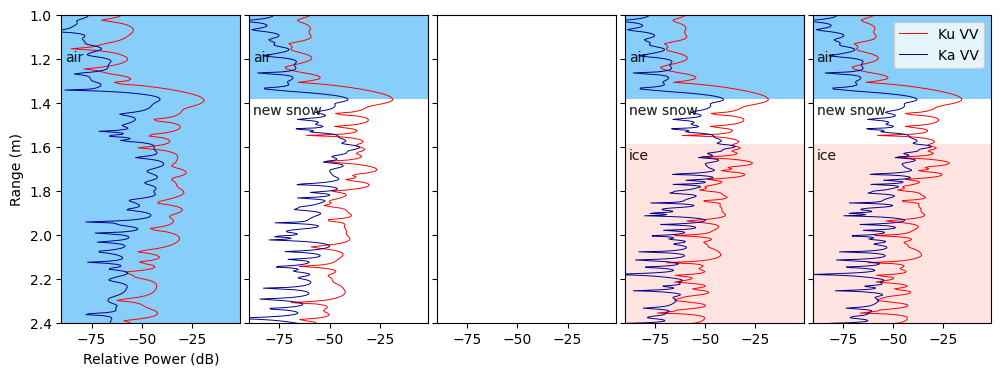

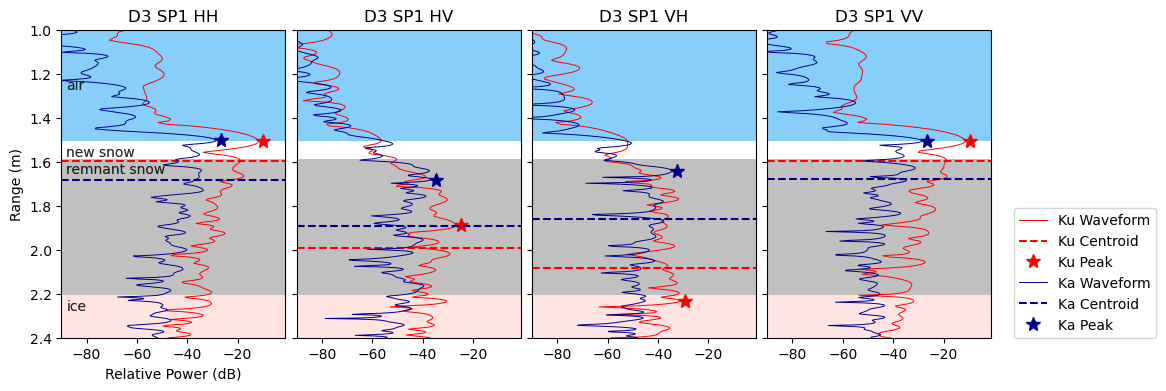

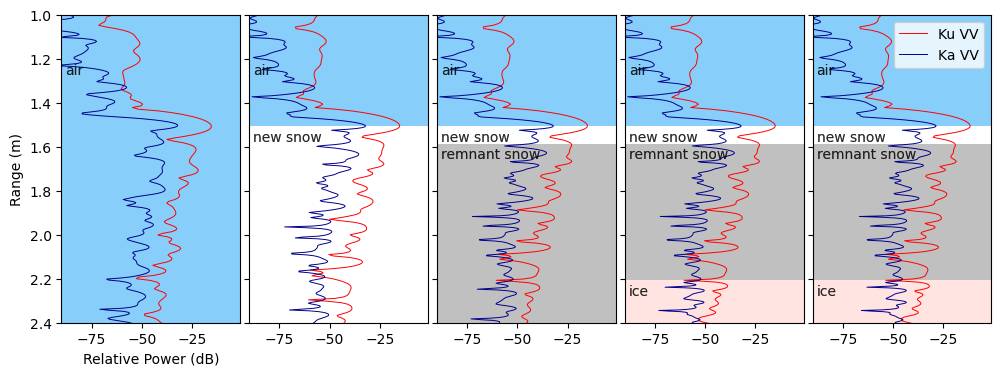

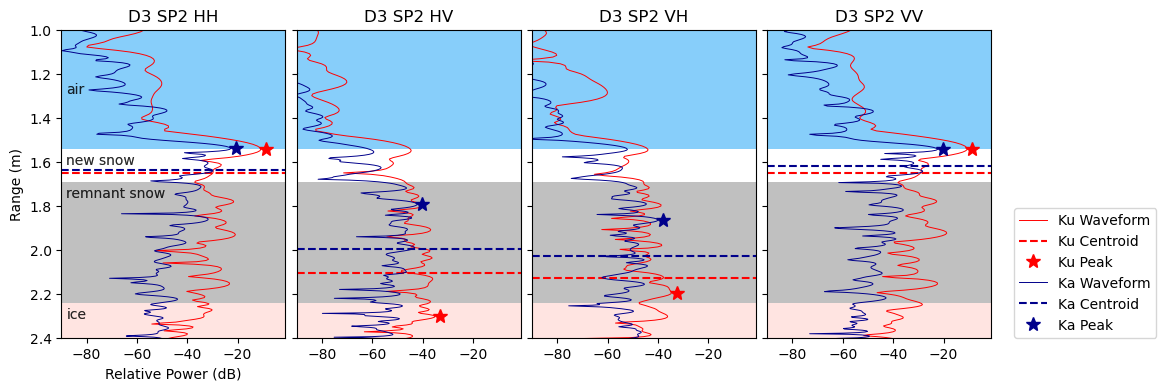

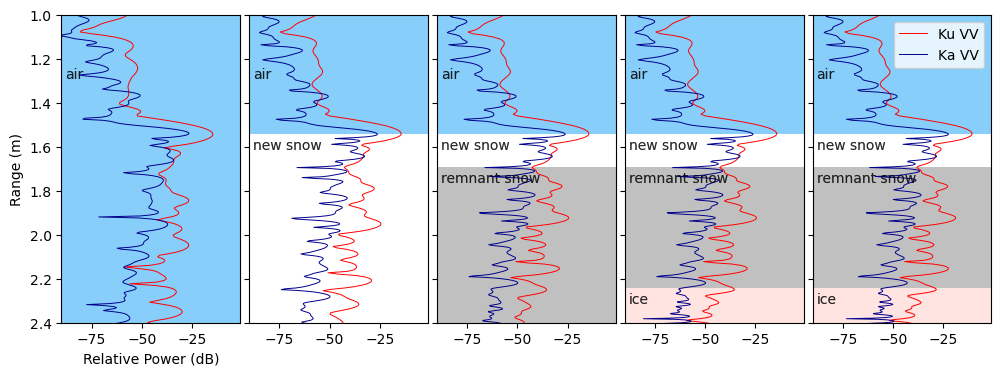

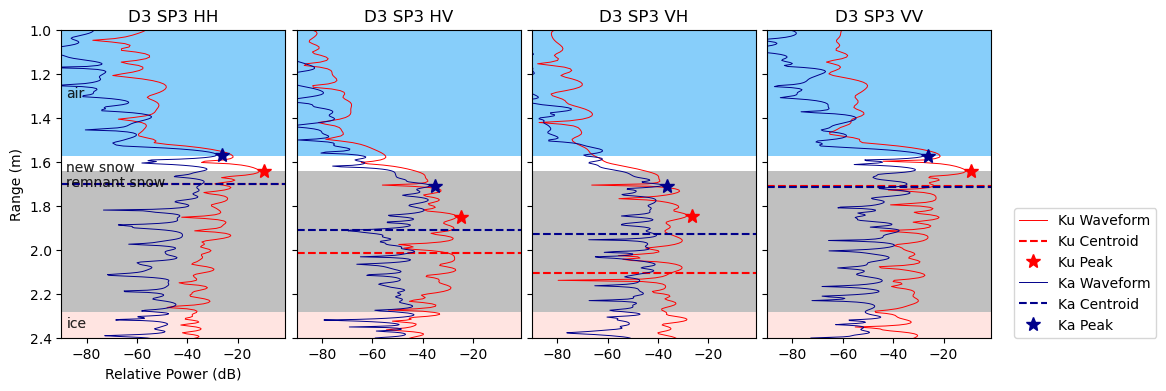

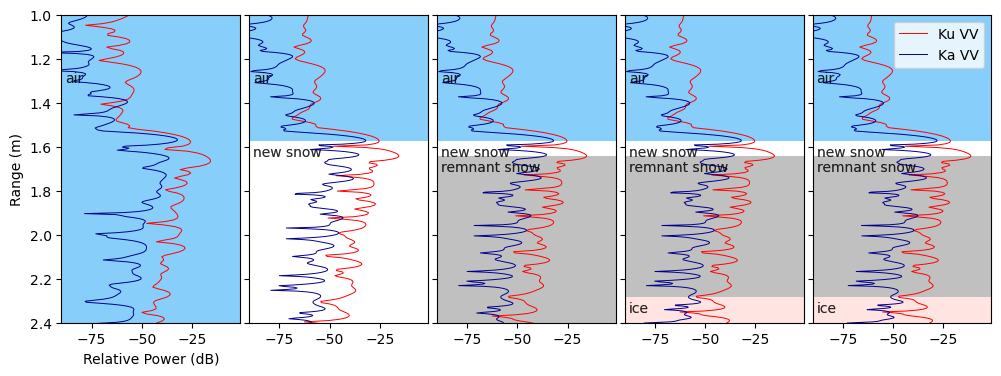

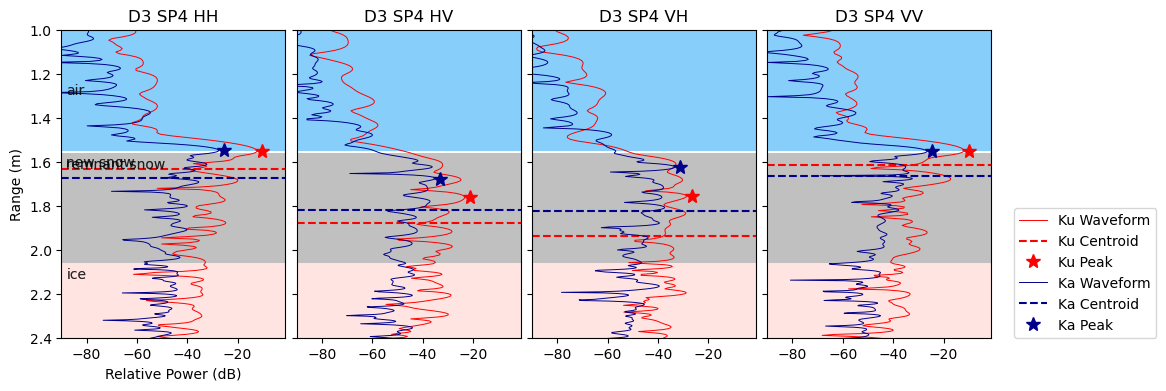

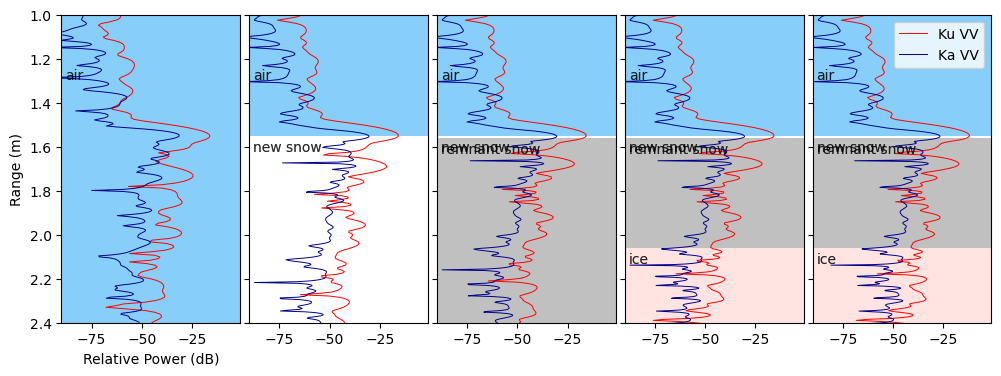

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


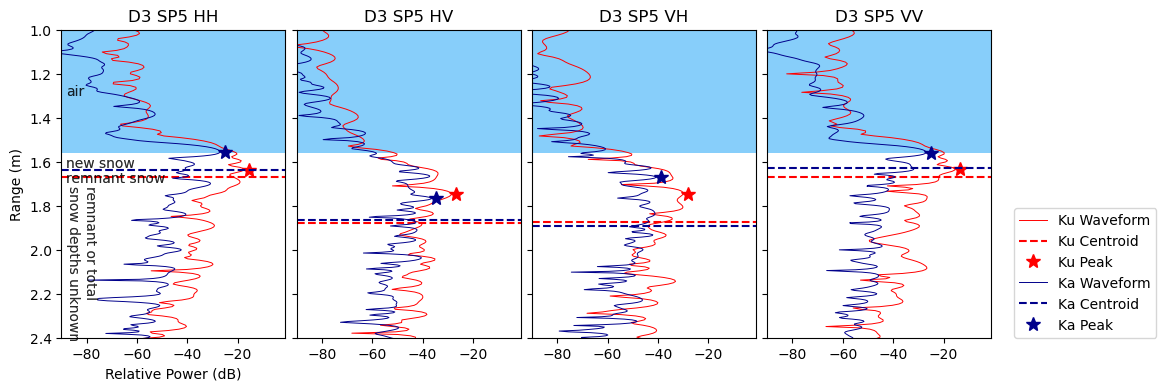

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


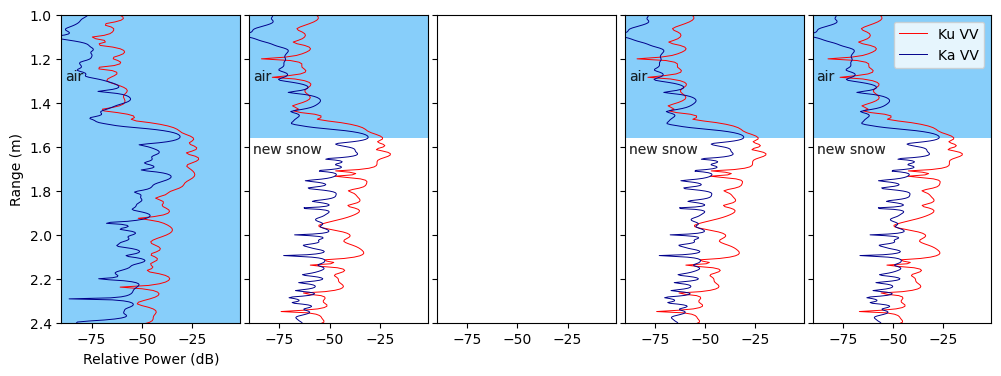

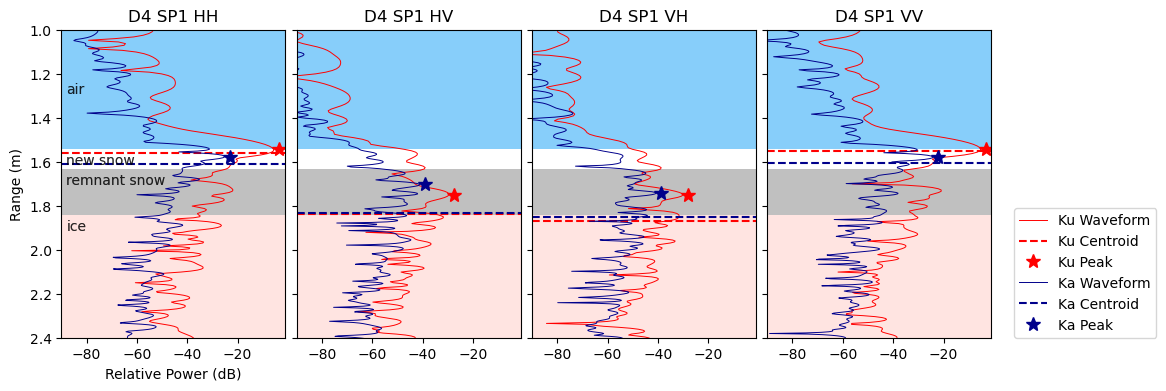

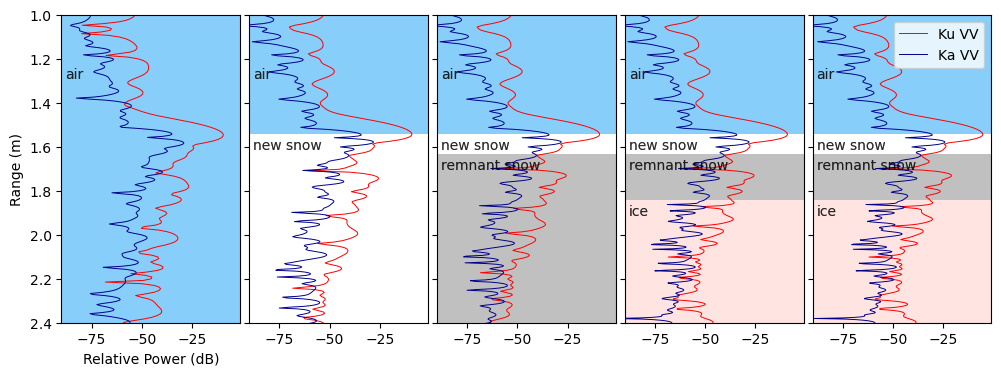

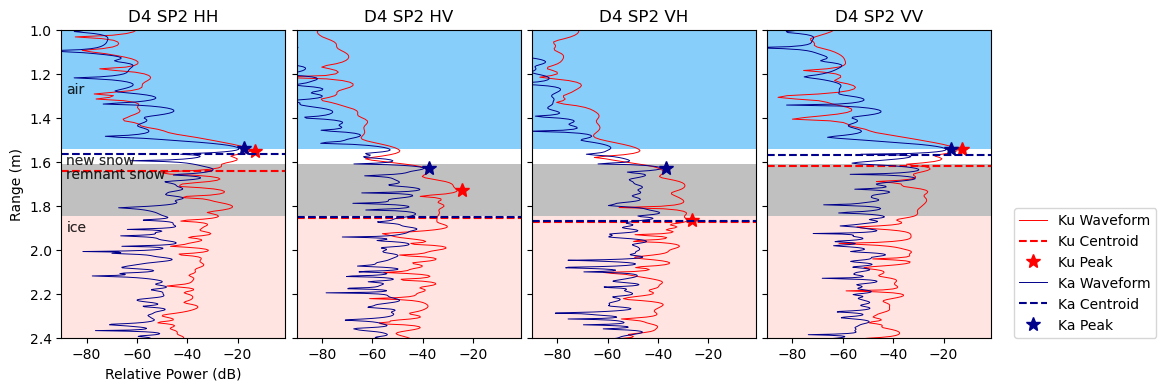

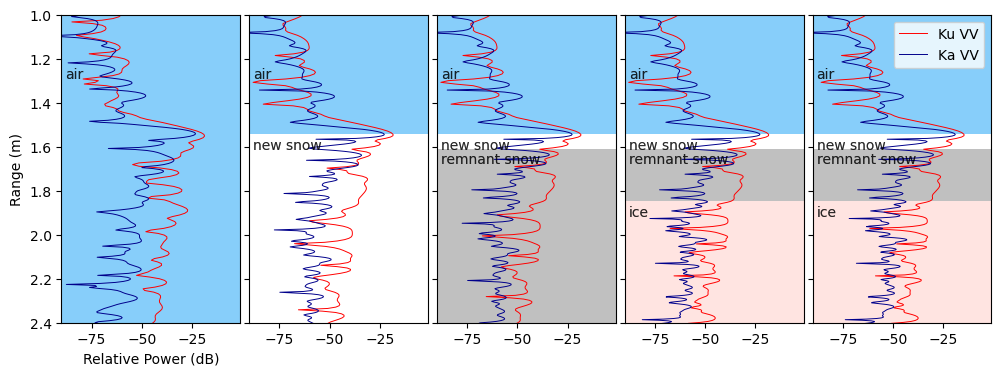

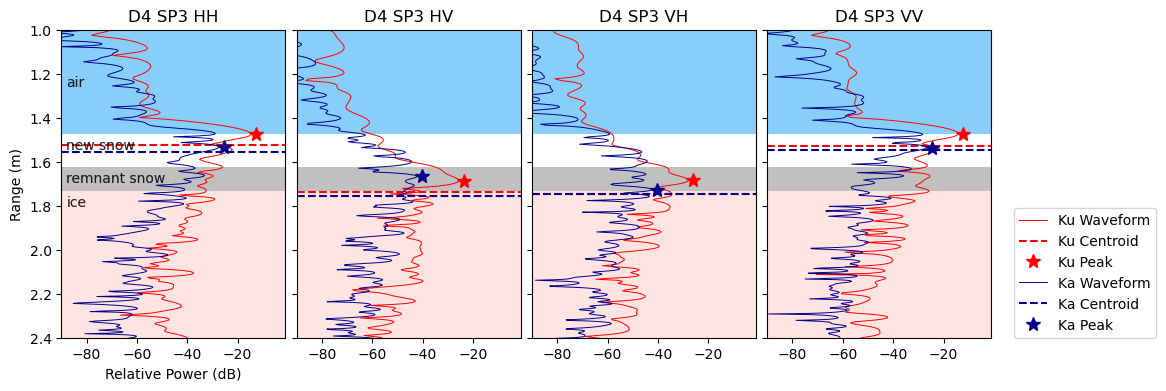

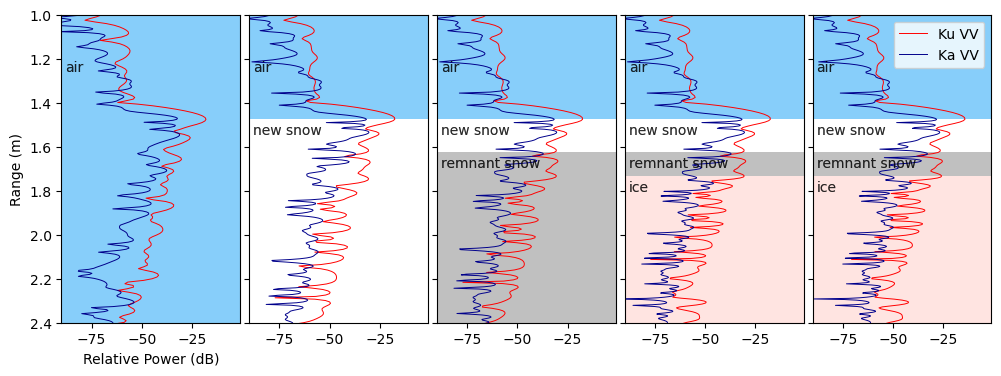

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


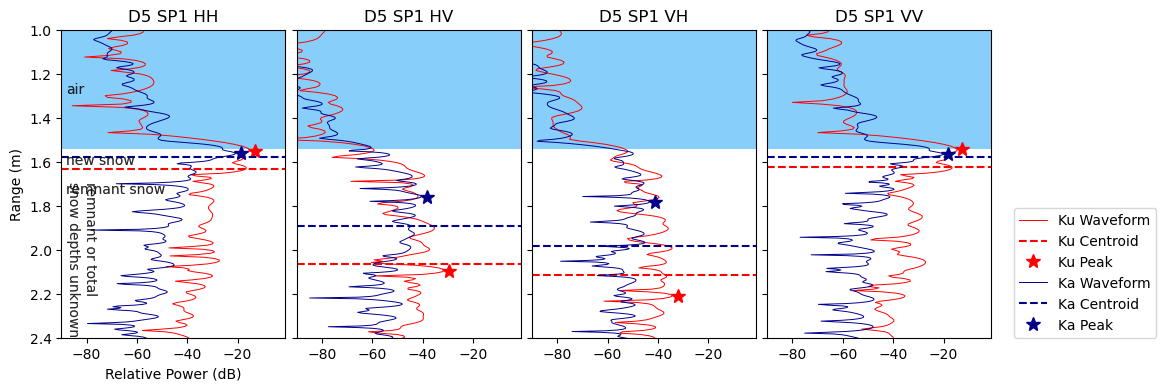

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


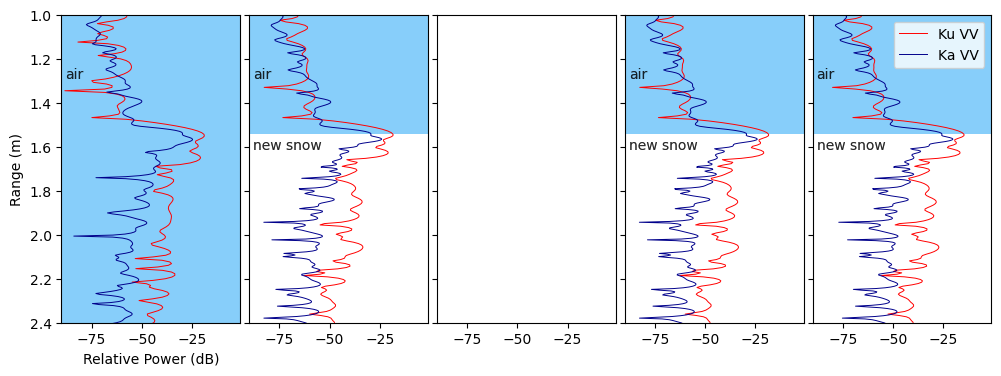

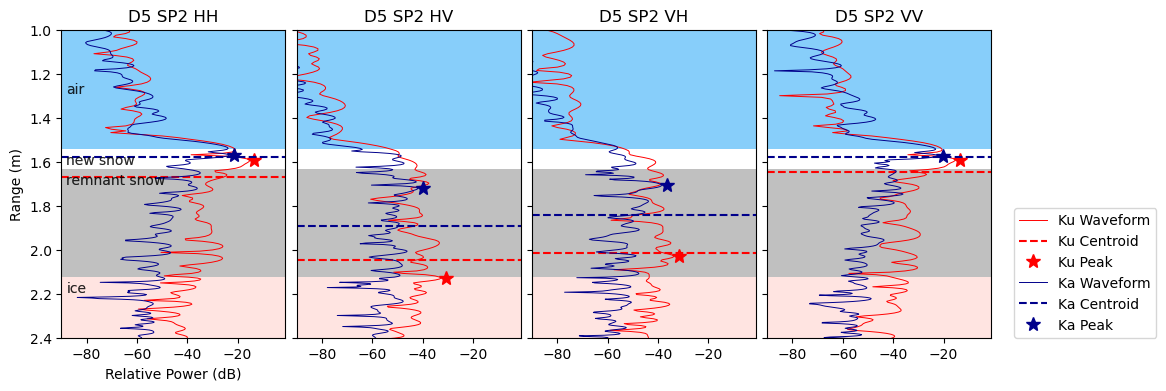

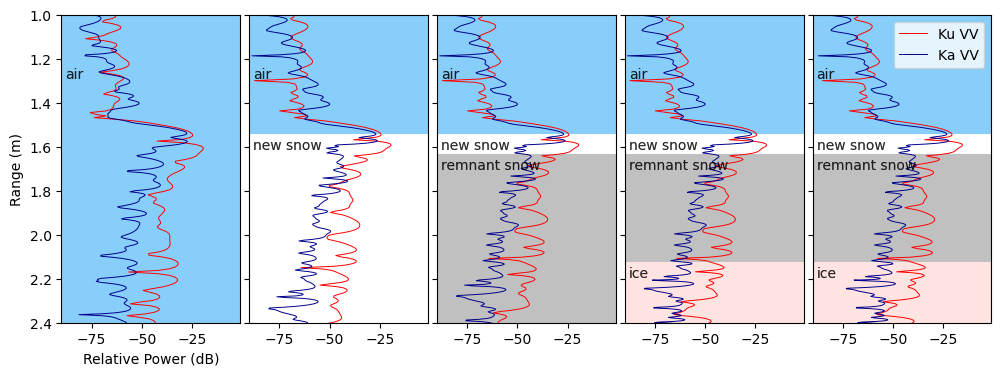

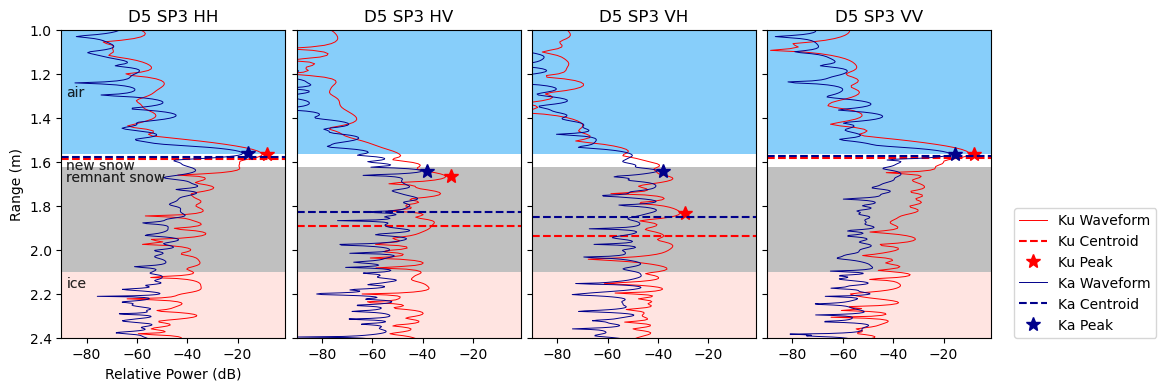

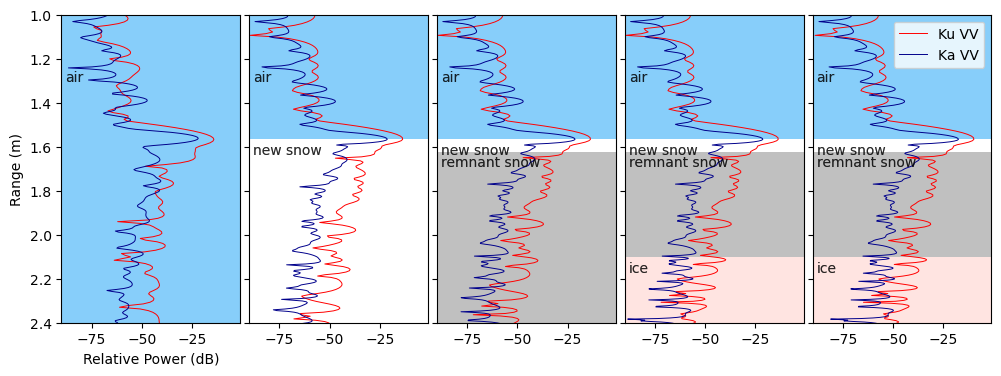

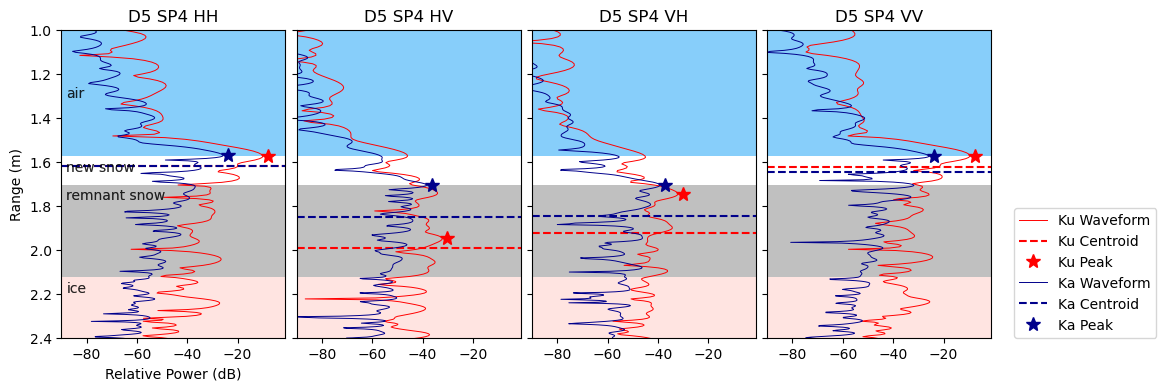

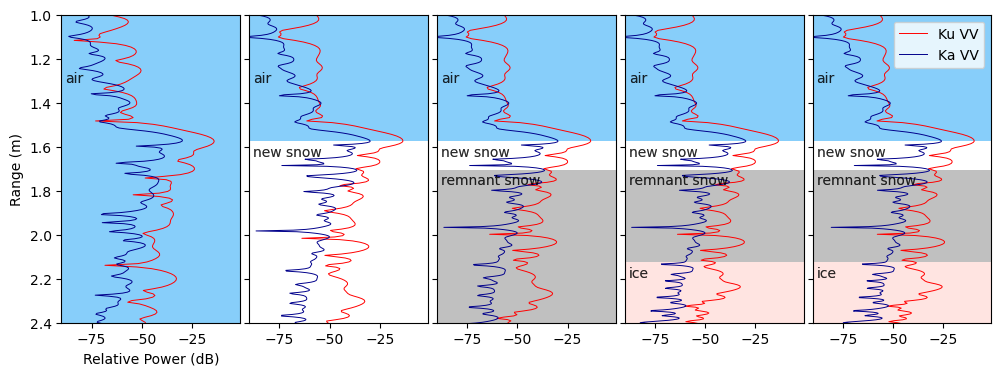

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


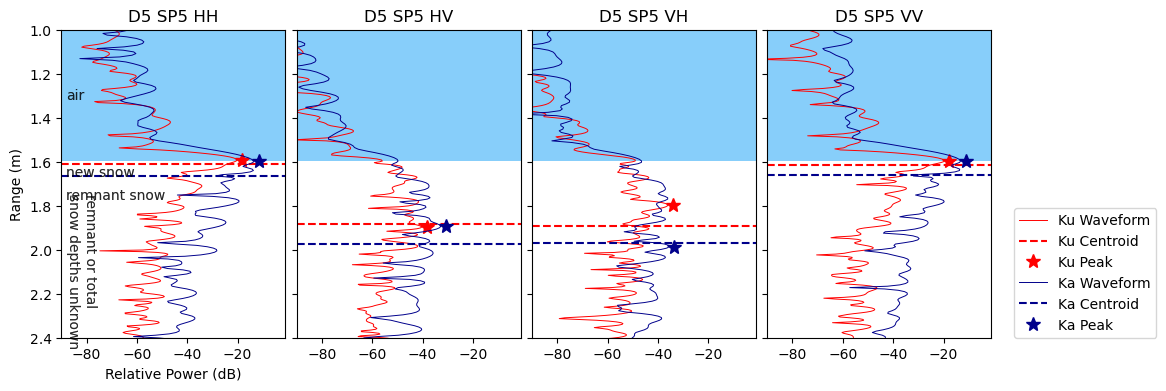

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


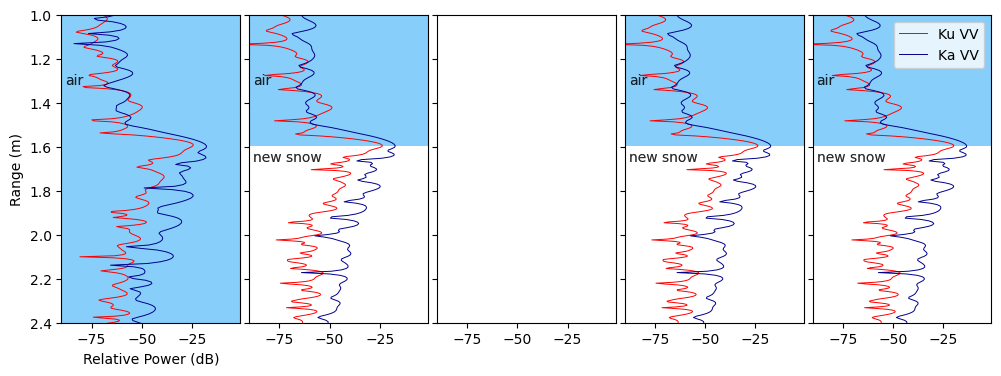

In [15]:
#make illustrative plots of air, snow and ice with waveforms overlaid
#calculate ranges of peaks and centroids

pols = ['hh', 'hv', 'vh', 'vv'] #polarisations to plot
band = ['ku', 'ka'] #frequency bands
col = ['r', 'darkblue'] #colours for ku and ka lines
show_r4 = False #show r4 adjustment as well as r2 (for spreading)

#plot info
xlim = [-90, -1]
ylim = [2.4, 1.]
ylim_g = ylim.copy()
xoffset = 2
lcol = 'k'
va = 'center'
alpha = .6 #for text

linewidth = .7 #for adjustments plot

#set search range to look for peaks, in metres
start = 1.
stop = 3

#make a dict to store calculated waveform info
summ = {'iface':       {'ku':{'as':[], 'nb':[], 'si':[], 'tot':[]},
                        'ka':{'as':[], 'nb':[], 'si':[], 'tot':[]}},    
        'peak_adj':    {'ku':{'hh':[], 'hv':[], 'vh':[], 'vv':[]},
                        'ka':{'hh':[], 'hv':[], 'vh':[], 'vv':[]}},
        'cen_adj':     {'ku':{'hh':[], 'hv':[], 'vh':[], 'vv':[]},
                        'ka':{'hh':[], 'hv':[], 'vh':[], 'vv':[]}},
        'peak_orig':   {'ku':{'hh':[], 'hv':[], 'vh':[], 'vv':[]},
                        'ka':{'hh':[], 'hv':[], 'vh':[], 'vv':[]}},
        'cen_orig':    {'ku':{'hh':[], 'hv':[], 'vh':[], 'vv':[]},
                        'ka':{'hh':[], 'hv':[], 'vh':[], 'vv':[]}},
        'peak_adj_r2': {'ku':{'hh':[], 'hv':[], 'vh':[], 'vv':[]},
                        'ka':{'hh':[], 'hv':[], 'vh':[], 'vv':[]}},
        'cen_adj_r2':  {'ku':{'hh':[], 'hv':[], 'vh':[], 'vv':[]},
                        'ka':{'hh':[], 'hv':[], 'vh':[], 'vv':[]}},
        'peak_orig_r2':{'ku':{'hh':[], 'hv':[], 'vh':[], 'vv':[]},
                        'ka':{'hh':[], 'hv':[], 'vh':[], 'vv':[]}},
        'cen_orig_r2': {'ku':{'hh':[], 'hv':[], 'vh':[], 'vv':[]},
                        'ka':{'hh':[], 'hv':[], 'vh':[], 'vv':[]}},
        'peak_adj_r4': {'ku':{'hh':[], 'hv':[], 'vh':[], 'vv':[]},
                        'ka':{'hh':[], 'hv':[], 'vh':[], 'vv':[]}},
        'cen_adj_r4':  {'ku':{'hh':[], 'hv':[], 'vh':[], 'vv':[]},
                        'ka':{'hh':[], 'hv':[], 'vh':[], 'vv':[]}}}

for i in range(len(list_of_pits)):
    
    #find the index of current pit
    pit_index = np.where(np.array(rr2r_df['Pit Code']) == data['code'][i])[0][0]
            
    #plot adjusted waveforms, peaks and centroids
    f, ax = plt.subplots(1, 4, figsize = (12, 4), sharey = True, )
    f.subplots_adjust(wspace = .05)
    
    #plot processing steps
    if i == i:
        nplots = 5 if show_r4 == False else 6
        g, gax = plt.subplots(1, nplots, figsize = (12, 4), sharex = True, sharey = True)
        g.subplots_adjust(wspace = .05)
    
    #find the peak at the air/snow interface
    peak = data['vv'][i]['ku_first_max'].copy()
    
    #adjust range for reduced velocity in snow
    #find densities
    dens_new = rr2r_df['Snow Density Above'][pit_index]#/1000
    dens_old = rr2r_df['Snow Density Below'][pit_index]#/1000
    
    #convert density to proportion of speed of light in new and old snow using Hallikainen et al (1986)
    if dens_new == dens_new: #if density of new snow is known
        c_new = 1/np.sqrt(1+1.9*(float(dens_new)/1000))
    else:
        c_new = 1/np.sqrt(1+1.9*(280/1000)) #otherwise use the new snow average
    if (dens_old != 'Nan') & (dens_old != 'Could not sample'):
        c_old = 1/np.sqrt(1+1.9*(float(dens_old)/1000)) #if density of old snow is known
    else:
        c_old = 1/np.sqrt(1+1.9*(443/1000)) #otherwise use the old snow average
    
    #set value for ice 
    c_ice = 1/np.sqrt(3.)
    
    #make calculations and plots
    for b in band:
        
        bindex = np.where(np.array(band) == b)[0][0]
        
        #calculate width of each range bin in metres
        m_per_pixel = data['vv'][i][b + '_ranges'][1] - data['vv'][i][b + '_ranges'][0]
        
        #find bin and then range of air/snow interface
        peak_bin = np.argmin(abs(data['vv'][i][b + '_ranges'] - peak))
        summ['iface'][b]['as'].append(data['vv'][i][b + '_ranges'][peak_bin]) #in metres
                
        #find depth of base of new snow
        nb = summ['iface'][b]['as'][-1] + float(rr2r_df['New Snow Depth'][pit_index])/100
        summ['iface'][b]['nb'].append(nb) #in metres

        #find bin of snow/ice interface from adding snow depths
        #if old and new snow depths are known
        if (rr2r_df['Old Snow Depth'][pit_index] != 'NA') & (rr2r_df['Old Snow Depth'][pit_index] != 'Unknown'):
            si = summ['iface'][b]['nb'][-1] + float(rr2r_df['Old Snow Depth'][pit_index])/100 
        #else if there was no old snow
        elif rr2r_df['Old Snow Depth'][pit_index] == 'NA':
            print('remnant snow NA')
            si = nb
        else:
            si = np.nan
        summ['iface'][b]['si'].append(si) #in metres
        
        #find bin of snow/ice interface from total snow depths
        #if the total depth is known
        if rr2r_df['Total Depth'][pit_index] != 'Unknown':
            tot = summ['iface'][b]['as'][-1] + float(rr2r_df['Total Depth'][pit_index])/100
        #else set to nan
        else:
            tot = np.nan
        summ['iface'][b]['tot'].append(tot) #in metres

        #make array with adjusted range for reduced propagation speeds in adj_range
        j = 0 #set to VV to start off as ranges same for all pols
        adj_range = data[pols[j]][i][b + '_ranges'][:].copy()

        #first plot (0) show waveform scaled for air (no adjustment)
        gax[0].plot(10*np.log10(data[pols[j]][i][b + '_values'][:]), 
                    adj_range, color = col[bindex],linewidth = linewidth)
        gax[0].add_patch(Rectangle((xlim[0], ylim_g[1]), xlim[1] - xlim[0], ylim_g[0] - ylim_g[1],
                         facecolor = 'lightskyblue', fill=True)) #fill all with air
        gax[0].text(xlim[0] + xoffset, 0.5*(peak - ylim[1]) + ylim[1], 'air', va = va, 
                    color = lcol, alpha = alpha)
        gax[0].set_xlabel('Relative Power (dB)')
        gax[0].set_ylabel('Range (m)')
        gax[0].set_xlim(xlim)
        gax[0].set_ylim(ylim_g)
        
        #scale waveforms for new snow
        adj_range[peak_bin+1:] = peak + (adj_range[peak_bin+1:] - peak)*c_new

        #second plot (1) show waveform scaled for new snow
        gax[1].plot(10*np.log10(data[pols[3]][i][b + '_values'][:]), 
                    adj_range, color = col[bindex], linewidth = linewidth)
        gax[1].add_patch(Rectangle((xlim[0], ylim_g[1]), xlim[1] - xlim[0], ylim_g[0] - ylim_g[1],
                         facecolor = 'lightskyblue', 
                         fill=True))
        gax[1].add_patch(Rectangle((xlim[0], peak), xlim[1] - xlim[0], ylim_g[0] - peak,
        facecolor = 'white', fill=True))
        gax[1].text(xlim[0] + xoffset, 0.5*(peak - ylim[1]) + ylim[1], 'air', va = va, 
                    color = lcol, alpha = alpha)
        gax[1].text(xlim[0] + xoffset, peak + .05, 'new snow', va = va, color = lcol, alpha = alpha)

        if nb == nb: #if new and old snow depths known find the closest bin to new/old snow interface
            nb_bin = np.argmin(abs(adj_range - nb))
      
        #third plot (2) show waveform scaled for old snow (if present)
        if si == si: #
            adj_range[nb_bin+1:] = nb + (adj_range[nb_bin+1:] - nb)*c_old/c_new
            si_bin = np.argmin(abs(adj_range - si))
    
            gax[2].plot(10*np.log10(data[pols[3]][i][b + '_values'][:]), 
                        adj_range, color = col[bindex], linewidth = linewidth)
            gax[2].add_patch(Rectangle((xlim[0], 1), xlim[1] - xlim[0], ylim_g[0] - ylim_g[1],
                    facecolor = 'lightskyblue', fill=True))
            gax[2].add_patch(Rectangle((xlim[0], peak), xlim[1] - xlim[0], ylim_g[0] - peak,
                    facecolor = 'white', fill=True))
            gax[2].add_patch(Rectangle((xlim[0], nb), xlim[1] - xlim[0], ylim_g[0] - nb,
                    facecolor = 'silver', fill=True))
            gax[2].text(xlim[0] + xoffset, 0.5*(peak - ylim[1]) + ylim[1], 'air', va = va, 
                        color = lcol, alpha = alpha)
            gax[2].text(xlim[0] + xoffset, peak + .05, 'new snow', va = va, 
                        color = lcol, alpha = alpha)
            gax[2].text(xlim[0] + xoffset, nb + .05, 'remnant snow', va = va, 
                        color = lcol, alpha = alpha)
            
        #fourth plot (3) show waveform scaled for ice
        tot_bin = np.argmin(abs(adj_range - tot))
        if si == si: #if new and old snow
            adj_range[tot_bin+1:] = tot + (adj_range[tot_bin+1:] - tot)*c_ice/c_old
        elif tot == tot: #if only new snow
            adj_range[tot_bin+1:] = tot + (adj_range[tot_bin+1:] - tot)*c_ice/c_new
            
        gax[3].plot(10*np.log10(data[pols[3]][i][b + '_values'][:]), 
                    adj_range, color = col[bindex], linewidth = linewidth)
        gax[3].add_patch(Rectangle((xlim[0], 1), xlim[1] - xlim[0], ylim_g[0] - ylim_g[1],
                facecolor = 'lightskyblue', fill=True))
        gax[3].add_patch(Rectangle((xlim[0], peak), xlim[1] - xlim[0], ylim_g[0] - peak,
                facecolor = 'white', fill=True))
        gax[3].text(xlim[0] + xoffset, 0.5*(peak - ylim[1]) + ylim[1], 'air', va = va, 
                    color = lcol, alpha = alpha)
        gax[3].text(xlim[0] + xoffset, peak + .05, 'new snow', va = va, 
                color = lcol, alpha = alpha)

        if si == si:
            gax[3].add_patch(Rectangle((xlim[0], nb), xlim[1] - xlim[0], ylim_g[0] - nb,
                    facecolor = 'silver', fill=True))
            gax[3].text(xlim[0] + xoffset, nb + .05, 'remnant snow', va = va, 
                        color = lcol, alpha = alpha)
        gax[3].add_patch(Rectangle((xlim[0], tot), xlim[1] - xlim[0], ylim_g[0] - tot,
                 facecolor = 'mistyrose', fill=True))        
        gax[3].text(xlim[0] + xoffset, tot + .05, 'ice', va = va, 
                    color = lcol, alpha = alpha)

        #fifth plot (4) show waveform scaled for r2
        gax[4].plot(10*np.log10(np.multiply(data[pols[3]][i][b + '_values'][:], adj_range**2)), 
                    adj_range, color = col[bindex], linewidth = linewidth, 
                    label = b[0].upper() + b[1] + ' ' + pols[3].upper())
        gax[4].add_patch(Rectangle((xlim[0], 1), xlim[1] - xlim[0], ylim_g[0] - ylim_g[1],
                facecolor = 'lightskyblue', fill=True))
        gax[4].add_patch(Rectangle((xlim[0], peak), xlim[1] - xlim[0], ylim_g[0] - peak,
                facecolor = 'white', fill=True))
        gax[4].add_patch(Rectangle((xlim[0], tot), xlim[1] - xlim[0], ylim_g[0] - tot,
                 facecolor = 'mistyrose', fill=True))
        gax[4].text(xlim[0] + xoffset, 0.5*(peak - ylim[1]) + ylim[1], 'air', va = va, 
                    color = lcol, alpha = alpha)
        gax[4].text(xlim[0] + xoffset, peak + .05, 'new snow', va = va, 
                color = lcol, alpha = alpha)


        if si == si:
            gax[4].add_patch(Rectangle((xlim[0], nb), xlim[1] - xlim[0], ylim_g[0] - nb,
                    facecolor = 'silver', fill=True))
            gax[4].text(xlim[0] + xoffset, nb + .05, 'remnant snow', va = va, 
                        color = lcol, alpha = alpha)
        gax[4].add_patch(Rectangle((xlim[0], tot), xlim[1] - xlim[0], ylim_g[0] - tot,
                 facecolor = 'mistyrose', fill=True))        
        gax[4].text(xlim[0] + xoffset, tot + .05, 'ice', va = va, 
                    color = lcol, alpha = alpha)

        
        if show_r4 == False:
            gax[4].legend()
        elif show_r4 == True:
        
            #sixth plot (5) show waveform scaled for r2
            gax[5].plot(10*np.log10(np.multiply(data[pols[3]][i][b + '_values'][:], adj_range**4)), 
                        adj_range, color = col[bindex], linewidth = linewidth, 
                        label = b[0].upper() + b[1] + ' ' + pols[3].upper())
            gax[5].add_patch(Rectangle((xlim[0], 1), xlim[1] - xlim[0], ylim_g[0] - ylim_g[1],
                    facecolor = 'lightskyblue', fill=True))
            gax[5].add_patch(Rectangle((xlim[0], peak), xlim[1] - xlim[0], ylim_g[0] - peak,
                    facecolor = 'white', fill=True))
            gax[5].add_patch(Rectangle((xlim[0], tot), xlim[1] - xlim[0], ylim_g[0] - tot,
                     facecolor = 'mistyrose', fill=True))
            gax[5].text(xlim[0] + xoffset, 0.5*(peak - ylim[1]) + ylim[1], 'air', va = va, 
                        color = lcol, alpha = alpha)
            gax[5].text(xlim[0] + xoffset, peak + .05, 'new snow', va = va, 
                    color = lcol, alpha = alpha)
            
            if si == si:
                gax[5].add_patch(Rectangle((xlim[0], nb), xlim[1] - xlim[0], ylim_g[0] - nb,
                        facecolor = 'silver', fill=True))
                gax[5].text(xlim[0] + xoffset, nb + .05, 'old snow', va = va, 
                            color = lcol, alpha = alpha)
            gax[5].add_patch(Rectangle((xlim[0], tot), xlim[1] - xlim[0], ylim_g[0] - tot,
                     facecolor = 'mistyrose', fill=True))        
            gax[5].text(xlim[0] + xoffset, tot + .05, 'ice', va = va, 
                        color = lcol, alpha = alpha)
            gax[5].legend()

        g.savefig('../figures/'+ data['code'][i] + 'proc_steps_new.jpg', dpi = 300, 
                  bbox_inches = 'tight')

        
        #now for each polarisation find the highest amplitude peaks and centroids, and plot
        for j in range(4):
    
            #find part of waveform to search for the peak

            #no adj search - where to look in waveform
            search_lims =      [np.argmin(abs(data[pols[j]][i][b + '_ranges'] - start)), 
                                np.argmin(abs(data[pols[j]][i][b + '_ranges'] - stop))]
            search =            np.arange(search_lims[1] - search_lims[0]) + search_lims[0]
            
            #adj search - where to look in waveform
            search_adj_lims =  [np.argmin(abs(adj_range - start)), np.argmin(abs(adj_range - stop))]
            search_adj =        np.arange(search_lims[1] - search_lims[0]) + search_lims[0]
            
            
            #get the values and ranges
            ranges = data[pols[j]][i][b + '_ranges'][search]
            ranges_adj = adj_range[search_adj]
            
            values = data[pols[j]][i][b + '_values'][search]
            values_r2 = np.multiply(values, ranges**2)
            values_r4 = np.multiply(values, ranges**4)
            values_adj = data[pols[j]][i][b + '_values'][search_adj]
            values_adj_r2 = np.multiply(values_adj, ranges_adj**2)
            values_adj_r4 = np.multiply(values_adj, ranges_adj**4)
            
            #find peaks
            #no r2, no adj
            mp = np.argmax(values) 
            summ['peak_orig'][b][pols[j]].append(ranges[mp])
            
            #no r2, adj
            mp_adj = np.argmax(values_adj)
            summ['peak_adj'][b][pols[j]].append(ranges_adj[mp_adj])
            
            #r2, no adj
            mp_r2 = np.argmax(values_r2)
            summ['peak_orig_r2'][b][pols[j]].append(ranges[mp_r2])
            
            #r2, adj
            mp_adj_r2 = np.argmax(values_adj_r2)
            summ['peak_adj_r2'][b][pols[j]].append(ranges_adj[mp_adj_r2])
 
            #r4, adj
            mp_adj_r4 = np.argmax(values_adj_r4)
            summ['peak_adj_r4'][b][pols[j]].append(ranges_adj[mp_adj_r4])

            
            #find the centroids                         
            #no r2, no adj
            cen_orig = np.sum(np.multiply(values, ranges))/np.sum(values)
            summ['cen_orig'][b][pols[j]].append(cen_orig)
            
            #no r2, adj
            cen_adj = np.sum(np.multiply(values_adj, ranges_adj))/np.sum(values_adj)
            summ['cen_adj'][b][pols[j]].append(cen_adj)
                             
            #r2, no adj
            cen_orig_r2 = np.sum(np.multiply(values_r2, ranges))/(np.sum(values_r2))
            summ['cen_orig_r2'][b][pols[j]].append(cen_orig_r2)
            
            #r2, adj
            cen_adj_r2 = np.sum(np.multiply(values_adj_r2, ranges_adj))/(np.sum(values_adj_r2))
            summ['cen_adj_r2'][b][pols[j]].append(cen_adj_r2)
            
            #r4, adj
            cen_adj_r4 = np.sum(np.multiply(values_adj_r4, ranges_adj))/(np.sum(values_adj_r4))
            summ['cen_adj_r4'][b][pols[j]].append(cen_adj_r4)

                
            #plot the waveform with original ranges
#             ax[j].plot(10*np.log10(values), ranges, 
#                        color = col[bindex], linestyle = ':', alpha = .5, 
#                            label = b[0].upper() + b[1] + ' original')
            
            #plot the waveform with r2 adjustment and ranges adjusted
            ax[j].plot(10*np.log10(values_adj_r2), ranges_adj,
                       color = col[bindex], linestyle = '-', linewidth = linewidth,
                       label = b[0].upper() + b[1] + ' Waveform')

            #colour the air
            ax[j].add_patch(Rectangle((xlim[0], ylim[1]), xlim[1] - xlim[0], peak - ylim[1],
                         facecolor = 'lightskyblue', 
                         fill=True))
            
            #colour the new snow 
            ax[j].add_patch(Rectangle((xlim[0], peak), xlim[1] - xlim[0], nb - peak ,
                         facecolor = 'white',
                         fill=True))
            
            #colour the old snow
            ax[j].add_patch(Rectangle((xlim[0], nb), xlim[1] - xlim[0], si - nb,
                         facecolor = 'silver',
                         fill=True))
            
            #colour the ice
            ax[j].add_patch(Rectangle((xlim[0], tot), xlim[1] - xlim[0], ylim[0] - tot,
                         facecolor = 'mistyrose', 
                         fill=True))
            
            #plot the centroids
            ax[j].plot(xlim, [cen_adj_r2, cen_adj_r2], color = col[bindex], 
                       linestyle = '--', label = b[0].upper() + b[1] + ' Centroid') 

            #star on highest amplitude peaks
            star_offset = 3

            ax[j].plot(10*np.log10(values_adj_r2[mp_adj_r2]) + xoffset, 
                       summ['peak_adj_r2'][b][pols[j]][-1], 
                       color = col[bindex], marker = '*', 
#                        s = 80, 
                       markersize = 10, linewidth = 0,
                       label = b[0].upper() + b[1] + ' Peak')
            
            #format plot
            ax[j].set_title(data['code'][i] + ' ' + pols[j].upper())
            ax[j].set_xlim(xlim)
            ax[j].set_ylim(ylim)
            
        #label the plot
        ax[0].text(xlim[0] + xoffset, 0.5*(peak - ylim[1]) + ylim[1], 'air', va = va, 
                    color = lcol, alpha = alpha)
        ax[0].text(xlim[0] + xoffset, peak + .05, 'new snow', va = va, color = lcol, alpha = alpha)
        ax[0].text(xlim[0] + xoffset, nb + .05, 'remnant snow', va = va, color = lcol, alpha = alpha)
        ax[0].text(xlim[0] + xoffset, tot + .05, 'ice', va = va, color = lcol, alpha = alpha)
        
        ax[0].set_ylabel('Range (m)')
        ax[0].set_xlabel('Relative Power (dB)')
        
        ax[3].legend(loc = [1.1, 0.0])
                
        if tot != tot:
            
            ax[0].text(xlim[0] + xoffset, peak + .5, 
                        'remnant or total\nsnow depths unknown', 
                        va = va, color = lcol, alpha = alpha,
                        rotation = -90)
   
    f.savefig('../figures/' + data['code'][i] + '_new.jpg', bbox_inches = 'tight',dpi = 300)
    # plt.show()
    

Now make scatter plots of the KuKa-derived vs measured snow depths

c_prime 0.7664068776774468
ok 14
[ 0  1  2  3  4  5  6  7  9 10 11 13 14 15]
x [0.3   0.28  0.53  0.205 0.7   0.7   0.71  0.51    nan 0.3   0.305 0.26
   nan 0.58  0.535 0.55    nan]
ok 14
[ 0  1  2  3  4  5  6  7  9 10 11 13 14 15]
x [0.3   0.28  0.53  0.205 0.7   0.7   0.71  0.51    nan 0.3   0.305 0.26
   nan 0.58  0.535 0.55    nan]
ok 14
[ 0  1  2  3  4  5  6  7  9 10 11 13 14 15]
x [0.3   0.28  0.53  0.205 0.7   0.7   0.71  0.51    nan 0.3   0.305 0.26
   nan 0.58  0.535 0.55    nan]
ok 14
[ 0  1  2  3  4  5  6  7  9 10 11 13 14 15]
x [0.3   0.28  0.53  0.205 0.7   0.7   0.71  0.51    nan 0.3   0.305 0.26
   nan 0.58  0.535 0.55    nan]


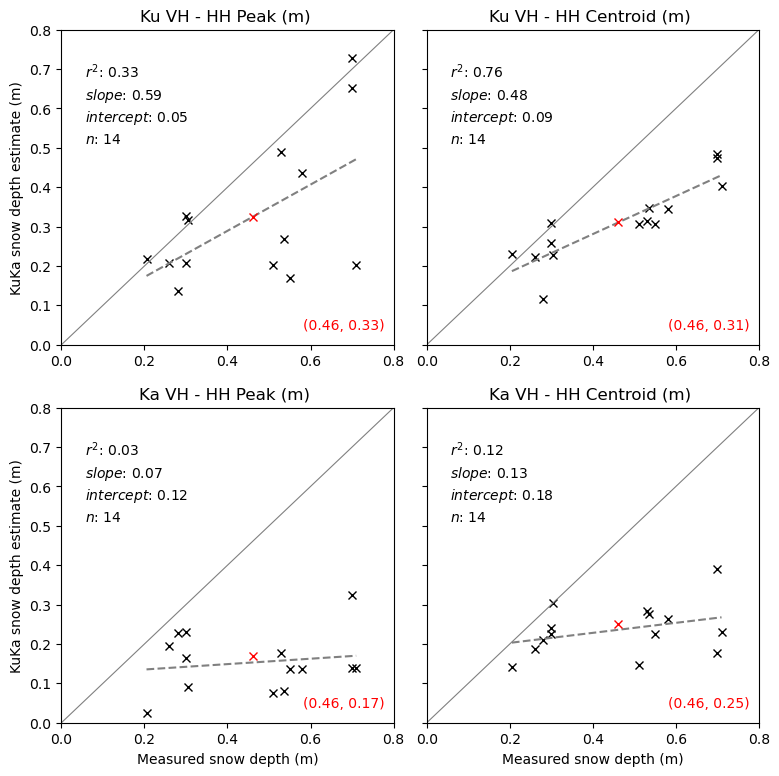

In [16]:
#paper TOTAL snow depth plots with r2

lim = [0, .8]
band = ['ku', 'ka']

c_prime = 1/np.sqrt(1+1.9*mean_bulk_dens/1000)

print('c_prime', c_prime)

f, ax = plt.subplots(2, 2, figsize = (9, 9), sharey  = True)
f.subplots_adjust(wspace = .1)

for r2 in ['_r2']:#,'_r4']:

    for b in band:
        
        row = 0 if b == 'ku' else 1
        
        for tech in ['cen_adj', 'peak_adj']:#, 'cen_orig', 'peak_orig']:

            if tech[0:3] == 'cen': add = 'Centroid' 
            elif tech[0:3] == 'pea': add = 'Peak'
                
            if tech[-3:] == 'adj': mult = 1
            elif tech[-3:] == 'rig': mult = c_prime
                
            column = 0 if tech[0:3] == 'pea' else 1

            pc = 'hh'
            px = 'vh'

            label = b[0].upper() + b[1] + ' ' + px.upper() + ' - ' + pc.upper() 

            x = np.array(summ['iface'][b]['tot']) - np.array(summ['iface'][b]['as'])
            y = (np.array(summ[tech + r2][b][px]) - np.array(summ[tech + r2][b][pc]))*mult

            ax[row, column].plot(x, y, 'kx')

            ok = np.where((x == x) & (y == y))[0]
            print('ok', len(ok))
            print(ok)
            print('x', x)
            slope, intercept, r_value, p_value, std_err = linregress(x[ok], y[ok])

            line_xs = np.array([min(x), max(x)])
            line_ys = slope*line_xs + intercept

            ax[row, column].plot(line_xs, line_ys,  'grey', linestyle = '--')

            ax[row, column].text(.07, .85, '$r^2$: ' + str(round(r_value**2, 2)), 
                                 transform=ax[row, column].transAxes)
            ax[row, column].text(.07, .78, '$slope$: ' + str(round(slope, 2)), 
                                 transform=ax[row, column].transAxes)
            ax[row, column].text(.07, .71, '$intercept$: ' + str(round(intercept, 2)), 
                                 transform=ax[row, column].transAxes)
            ax[row, column].text(.07, .64, '$n$: ' + str(len(ok)), transform=ax[row, column].transAxes)

            x_mean = np.mean(x[x == x])
            y_mean = np.mean(y[y == y])
            ax[row, column].plot(x_mean, y_mean, 'rx')
            coord = '(' + str(round(x_mean, 2)) + ', ' + str(round(y_mean, 2)) + ')'
            ax[row, column].text(.68, .04, coord, color = 'r', ha = 'center')

            ax[row, column].set_title(label + ' ' + add + ' (m) ')# + r2)
            ax[row, column].set_xlim(lim)
            ax[row, column].set_ylim(lim)
            ax[row, column].plot(lim, lim, 'grey', linewidth = .8)

            ax[0,0].set_ylabel('KuKa snow depth estimate (m)')
            ax[1,0].set_ylabel('KuKa snow depth estimate (m)')
            ax[1, 0].set_xlabel('Measured snow depth (m)')
            ax[1, 1].set_xlabel('Measured snow depth (m)')
            
            plt.savefig('../figures/adjusted_scatter_for_paper_total_snow_new.jpg',  
                    bbox_inches = 'tight', dpi = 300)



c_prime 0.7664068776774468
ok 13
[ 0  1  2  4  5  6  7  9 10 11 13 14 15]
x [0.18 0.1  0.43  nan 0.62 0.55 0.64 0.5   nan 0.21 0.24 0.11  nan 0.49
 0.48 0.42  nan]
y [0.25766457 0.11533762 0.3147115  0.23072268 0.48467709 0.47492417
 0.40391478 0.30752554 0.20508823 0.30959831 0.22812627 0.22393216
 0.48074885 0.34500692 0.34776909 0.30691621 0.27754822]
ok 13
[ 0  1  2  4  5  6  7  9 10 11 13 14 15]
x [0.18 0.1  0.43  nan 0.62 0.55 0.64 0.5   nan 0.21 0.24 0.11  nan 0.49
 0.48 0.42  nan]
y [0.32598286 0.13582824 0.48824926 0.21765246 0.72758946 0.65120536
 0.20238998 0.20326671 0.10855462 0.20716137 0.31550936 0.20707781
 0.65971236 0.43621658 0.26844657 0.17063256 0.20503757]
ok 13
[ 0  1  2  4  5  6  7  9 10 11 13 14 15]
x [0.18 0.1  0.43  nan 0.62 0.55 0.64 0.5   nan 0.21 0.24 0.11  nan 0.49
 0.48 0.42  nan]
y [0.22600548 0.21135475 0.28386691 0.14034069 0.1767265  0.39120445
 0.22941824 0.14623678 0.25119078 0.24072563 0.30512749 0.1884162
 0.40693285 0.26442963 0.27556807 0.22595

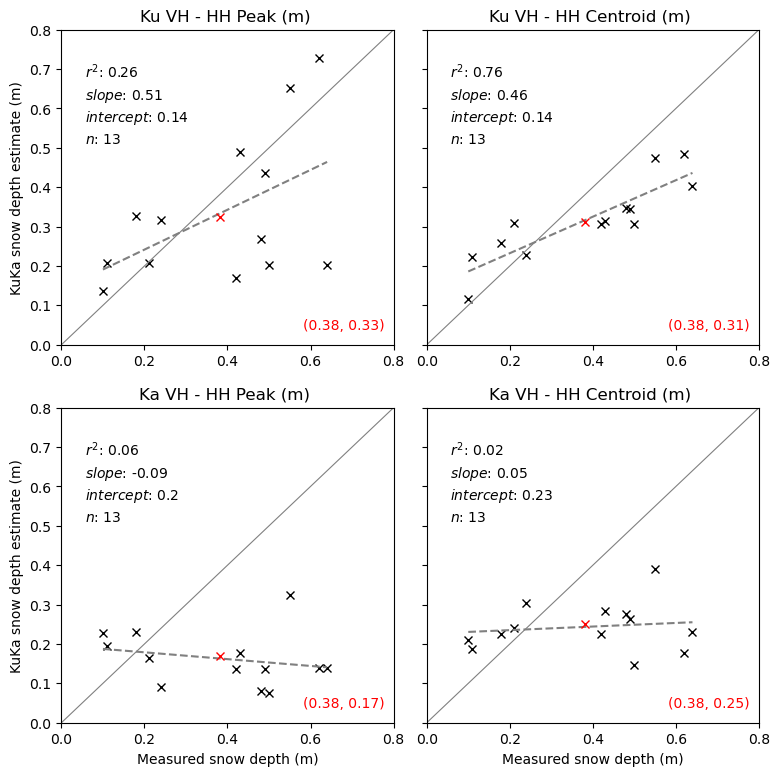

In [17]:
#paper OLD snow depths with r2

old_depth = np.array(rr2r_df['Old Snow Depth'][0:17])
old_depth[old_depth == 'Unknown'] = 'Nan'
old_depth = old_depth.astype(float)/100
old_depth

lim = [0, .8]
band = ['ku', 'ka']

c_prime = 1/np.sqrt(1+1.9*mean_bulk_dens/1000)

print('c_prime', c_prime)

f, ax = plt.subplots(2, 2, figsize = (9, 9), sharey  = True)
f.subplots_adjust(wspace = .1)

for r2 in ['_r2']:#,'_r4']:

    for b in band:
        
        row = 0 if b == 'ku' else 1
        
        for tech in ['cen_adj', 'peak_adj']:#, 'cen_orig', 'peak_orig']:

            if tech[0:3] == 'cen': add = 'Centroid' 
            elif tech[0:3] == 'pea': add = 'Peak'
                
            if tech[-3:] == 'adj': mult = 1
            elif tech[-3:] == 'rig': mult = c_prime
                
            column = 0 if tech[0:3] == 'pea' else 1

            pc = 'hh'
            px = 'vh'

            label = b[0].upper() + b[1] + ' ' + px.upper() + ' - ' + pc.upper() 

            x = old_depth
            y = (np.array(summ[tech + r2][b][px]) - np.array(summ[tech + r2][b][pc]))*mult

            ax[row, column].plot(x, y, 'kx')

            ok = np.where((x == x) & (y == y))[0]
            print('ok', len(ok))
            print(ok)
            print('x', x)
            print('y', y)

            slope, intercept, r_value, p_value, std_err = linregress(x[ok], y[ok])

            line_xs = np.array([min(x), max(x)])
            line_ys = slope*line_xs + intercept
                
            ax[row, column].plot(line_xs, line_ys,  'grey', linestyle = '--')

            ax[row, column].text(.07, .85, '$r^2$: ' + str(round(r_value**2, 2)), 
                                 transform=ax[row, column].transAxes)
            ax[row, column].text(.07, .78, '$slope$: ' + str(round(slope, 2)), 
                                 transform=ax[row, column].transAxes)
            ax[row, column].text(.07, .71, '$intercept$: ' + str(round(intercept, 2)), 
                                 transform=ax[row, column].transAxes)
            ax[row, column].text(.07, .64, '$n$: ' + str(len(ok)), transform=ax[row, column].transAxes)

            x_mean = np.mean(x[x == x])
            y_mean = np.mean(y[y == y])
            ax[row, column].plot(x_mean, y_mean, 'rx')
            coord = '(' + str(round(x_mean, 2)) + ', ' + str(round(y_mean, 2)) + ')'
            ax[row, column].text(.68, .04, coord, color = 'r', ha = 'center')

            ax[row, column].set_title(label + ' ' + add + ' (m) ')# + r2)
            ax[row, column].set_xlim(lim)
            ax[row, column].set_ylim(lim)
            ax[row, column].plot(lim, lim, 'grey', linewidth = .8)

            ax[0,0].set_ylabel('KuKa snow depth estimate (m)')
            ax[1,0].set_ylabel('KuKa snow depth estimate (m)')
            ax[1, 0].set_xlabel('Measured snow depth (m)')
            ax[1, 1].set_xlabel('Measured snow depth (m)')

            plt.savefig('../figures/adjusted_scatter_for_paper_old_snow_NEW.jpg',  
                    bbox_inches = 'tight', dpi = 300)



c_prime 0.7664068776774468


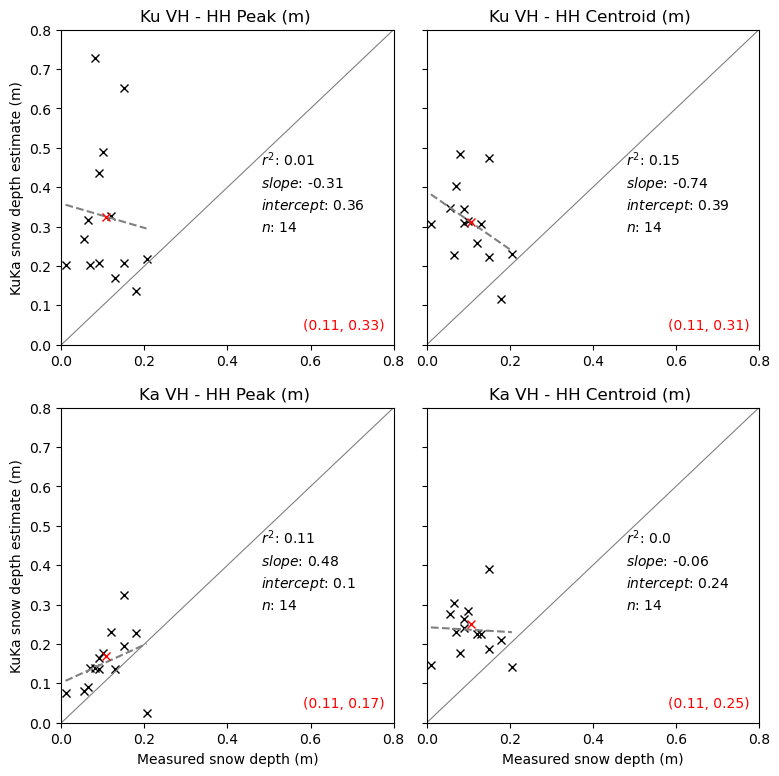

In [18]:
#paper NEW snow depth plots 

new_depth = np.array(rr2r_df['New Snow Depth'][0:17])
new_depth[new_depth == 'Unknown'] = 'Nan'
new_depth = new_depth.astype(float)/100
total_depth = np.array(summ['iface'][b]['tot']) - np.array(summ['iface'][b]['as'])
new_depth[total_depth != total_depth] = np.nan

lim = [0, .8]
band = ['ku', 'ka']

c_prime = 1/np.sqrt(1+1.9*mean_bulk_dens/1000)

print('c_prime', c_prime)

# print('using adjusted')

f, ax = plt.subplots(2, 2, figsize = (9, 9), sharey  = True)
f.subplots_adjust(wspace = .1)

for r2 in ['_r2']:#,'_r4']:


    for b in band:
        
        row = 0 if b == 'ku' else 1
        
        for tech in ['cen_adj', 'peak_adj']:#, 'cen_orig', 'peak_orig']:

            if tech[0:3] == 'cen': add = 'Centroid' 
            elif tech[0:3] == 'pea': add = 'Peak'
                
            if tech[-3:] == 'adj': mult = 1
            elif tech[-3:] == 'rig': mult = c_prime
                
            column = 0 if tech[0:3] == 'pea' else 1

            pc = 'hh'
            px = 'vh'

            label = b[0].upper() + b[1] + ' ' + px.upper() + ' - ' + pc.upper() 

            x = new_depth
            y = (np.array(summ[tech + r2][b][px]) - np.array(summ[tech + r2][b][pc]))*mult

            ax[row, column].plot(x, y, 'kx')

            ok = np.where((x == x) & (y == y))[0]
            slope, intercept, r_value, p_value, std_err = linregress(x[ok], y[ok])

            line_xs = np.array([min(x), max(x)])
            line_ys = slope*line_xs + intercept

            ax[row, column].plot(line_xs, line_ys,  'grey', linestyle = '--')

            ax[row, column].text(.6, .57, '$r^2$: ' + str(round(r_value**2, 2)), 
                                 transform=ax[row, column].transAxes)
            ax[row, column].text(.6, .50, '$slope$: ' + str(round(slope, 2)), 
                                 transform=ax[row, column].transAxes)
            ax[row, column].text(.6, .43, '$intercept$: ' + str(round(intercept, 2)), 
                                 transform=ax[row, column].transAxes)
            ax[row, column].text(.6, .36, '$n$: ' + str(len(ok)), transform=ax[row, column].transAxes)

            x_mean = np.mean(x[x == x])
            y_mean = np.mean(y[y == y])
            ax[row, column].plot(x_mean, y_mean, 'rx')
            coord = '(' + str(round(x_mean, 2)) + ', ' + str(round(y_mean, 2)) + ')'
            ax[row, column].text(.68, .04, coord, color = 'r', ha = 'center')

            ax[row, column].set_title(label + ' ' + add + ' (m) ')# + r2)
            ax[row, column].set_xlim(lim)
            ax[row, column].set_ylim(lim)
            ax[row, column].plot(lim, lim, 'grey', linewidth = .8)

            ax[0,0].set_ylabel('KuKa snow depth estimate (m)')
            ax[1,0].set_ylabel('KuKa snow depth estimate (m)')
            ax[1, 0].set_xlabel('Measured snow depth (m)')
            ax[1, 1].set_xlabel('Measured snow depth (m)')

            plt.savefig('../figures/adjusted_scatter_for_paper_new_snow_NEW.jpg',  
                    bbox_inches = 'tight', dpi = 300)


c_prime 0.7664068776774468


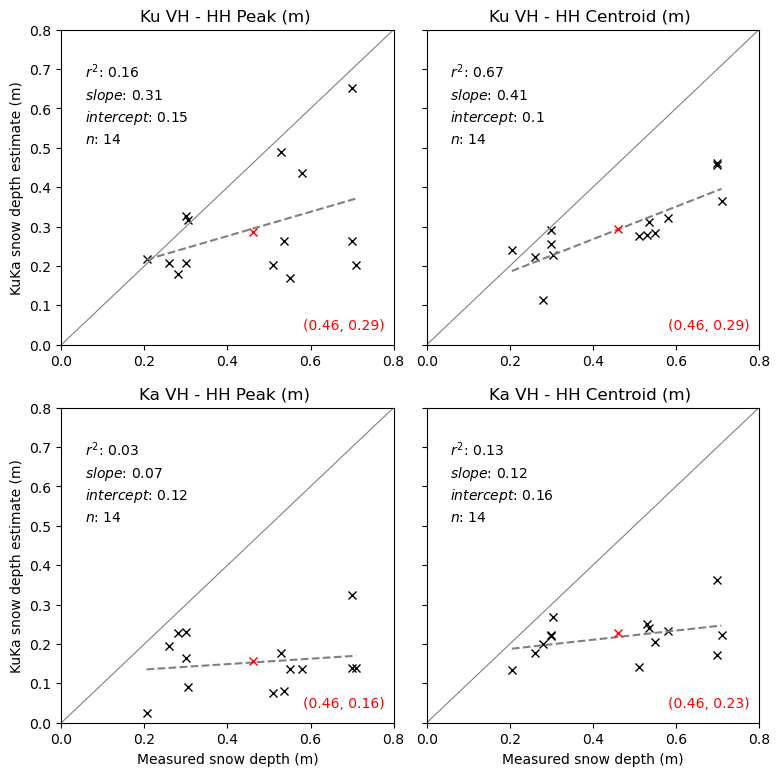

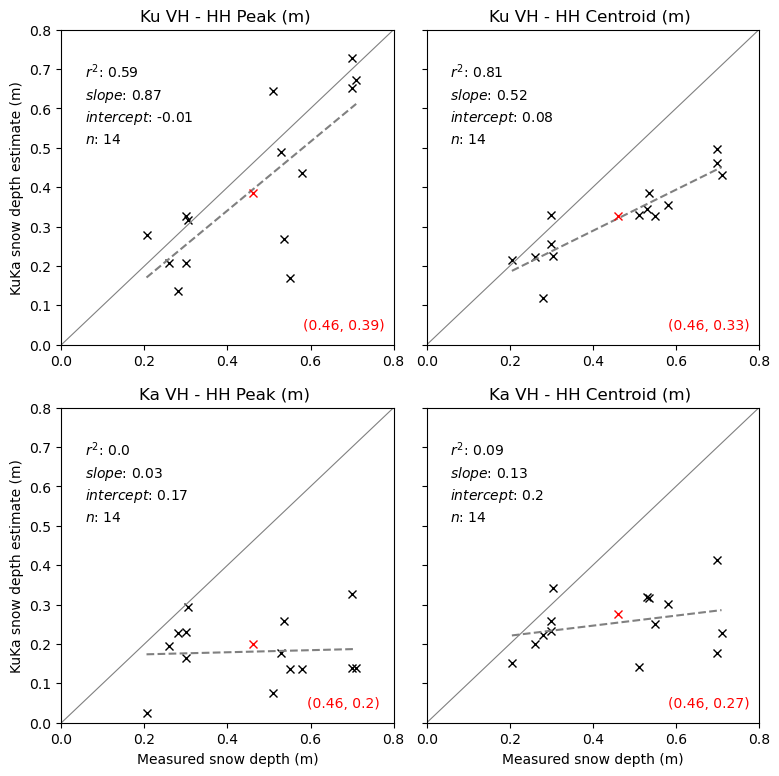

In [19]:
#paper TOTAL snow depth plots with no r adjustment and r4 spreading

lim = [0, .8]
band = ['ku', 'ka']

c_prime = 1/np.sqrt(1+1.9*mean_bulk_dens/1000)

print('c_prime', c_prime)


for r2 in ['', '_r4']:#,'_r4']:
    
    f, ax = plt.subplots(2, 2, figsize = (9, 9), sharey  = True)
    f.subplots_adjust(wspace = .1)

    for b in band:
        
        row = 0 if b == 'ku' else 1
        
        for tech in ['cen_adj', 'peak_adj']:#, 'cen_orig', 'peak_orig']:

            if tech[0:3] == 'cen': add = 'Centroid' 
            elif tech[0:3] == 'pea': add = 'Peak'
                
            if tech[-3:] == 'adj': mult = 1
            elif tech[-3:] == 'rig': mult = c_prime
                
            column = 0 if tech[0:3] == 'pea' else 1

            pc = 'hh'
            px = 'vh'

            label = b[0].upper() + b[1] + ' ' + px.upper() + ' - ' + pc.upper() 

            x = np.array(summ['iface'][b]['tot']) - np.array(summ['iface'][b]['as'])
            y = (np.array(summ[tech + r2][b][px]) - np.array(summ[tech + r2][b][pc]))*mult

            ax[row, column].plot(x, y, 'kx')

            ok = np.where((x == x) & (y == y))[0]
            slope, intercept, r_value, p_value, std_err = linregress(x[ok], y[ok])

            line_xs = np.array([min(x), max(x)])
            line_ys = slope*line_xs + intercept

            ax[row, column].plot(line_xs, line_ys,  'grey', linestyle = '--')

            ax[row, column].text(.07, .85, '$r^2$: ' + str(round(r_value**2, 2)), 
                                 transform=ax[row, column].transAxes)
            ax[row, column].text(.07, .78, '$slope$: ' + str(round(slope, 2)), 
                                 transform=ax[row, column].transAxes)
            ax[row, column].text(.07, .71, '$intercept$: ' + str(round(intercept, 2)), 
                                 transform=ax[row, column].transAxes)
            ax[row, column].text(.07, .64, '$n$: ' + str(len(ok)), transform=ax[row, column].transAxes)

            x_mean = np.mean(x[x == x])
            y_mean = np.mean(y[y == y])
            ax[row, column].plot(x_mean, y_mean, 'rx')
            coord = '(' + str(round(x_mean, 2)) + ', ' + str(round(y_mean, 2)) + ')'
            ax[row, column].text(.68, .04, coord, color = 'r', ha = 'center')

            ax[row, column].set_title(label + ' ' + add + ' (m) ')# + r2)
            ax[row, column].set_xlim(lim)
            ax[row, column].set_ylim(lim)
            ax[row, column].plot(lim, lim, 'grey', linewidth = .8)

            ax[0,0].set_ylabel('KuKa snow depth estimate (m)')
            ax[1,0].set_ylabel('KuKa snow depth estimate (m)')
            ax[1, 0].set_xlabel('Measured snow depth (m)')
            ax[1, 1].set_xlabel('Measured snow depth (m)')
            
            plt.savefig('../figures/adjusted_scatter_for_paper' + add + '_NEW.jpg',  
                    bbox_inches = 'tight', dpi = 300)
    plt.show()



ok [ 0  1  2  3  4  5  6  7  9 10 11 13 14 15]


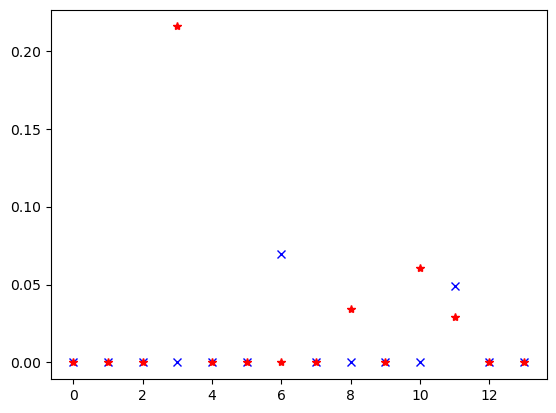

Ku VV highest amplitude peak at air snow interface: 86 %
Ka VV highest amplitude peak at air snow interface: 71 %


In [20]:
#print percentages VV peak at air/snow interface
total_depth = np.array(summ['iface'][b]['tot']) - np.array(summ['iface'][b]['as'])
ok = np.where(total_depth == total_depth)[0]
# ok = np.arange(17)
print('ok', ok)

r = 'r4'

#VV
ku_vv_pk_as = np.array(summ['peak_adj']['ku']['vv'])[ok] - np.array(summ['iface']['ku']['as'])[ok]
ka_vv_pk_as = np.array(summ['peak_adj']['ka']['vv'])[ok] - np.array(summ['iface']['ka']['as'])[ok]
plt.plot(ku_vv_pk_as, 'bx', label = 'Ku')
plt.plot(ka_vv_pk_as, 'r*', label = 'Ku')
plt.show()

print('Ku VV highest amplitude peak at air snow interface:', 
     round(np.where(ku_vv_pk_as == 0)[0].shape[0]/ku_vv_pk_as.shape[0]*100), '%')
print('Ka VV highest amplitude peak at air snow interface:', 
     round(np.where(ka_vv_pk_as == 0)[0].shape[0]/ka_vv_pk_as.shape[0]*100), '%')



In [21]:
#print ranges of the peaks and centroids in latex format
band = ['ku', 'ka']
pols = ['hh', 'vv', 'vh', 'hv', ]

print('F    p    pk     pk_sd  c    c_sd     p   p_sd cen cen_sd')

for b in band:
        
    for p in pols:

        #find depths of centroids and peaks relative to snow surface
        total_depth = np.array(summ['iface'][b]['tot']) - np.array(summ['iface'][b]['as'])
        cen_adj_r2_depth = np.array(summ['cen_adj_r2'][b][p]) - np.array(summ['iface'][b]['as'])
        peak_adj_r2_depth = np.array(summ['peak_adj_r2'][b][p]) - np.array(summ['iface'][b]['as'])
        
        #find which pits have total depth known 
        ok = np.where(np.array(summ['iface'][b]['tot']) == np.array(summ['iface'][b]['tot']))[0]
                
        #calculate depths in cm below air snow interface
        mean_cen =  str(round(np.nanmean(cen_adj_r2_depth[ok]),2))
        mean_peak = str(round(np.nanmean(peak_adj_r2_depth[ok]),2))
        std_cen =   str(round(np.nanstd(cen_adj_r2_depth[ok]),2))
        std_peak =  str(round(np.nanstd(peak_adj_r2_depth[ok]),2))
                
        #calculate depths in % total snow depth
        mean_cen_p =  str(round(100*np.nanmean(cen_adj_r2_depth/total_depth)))
        mean_peak_p = str(round(100*np.nanmean(peak_adj_r2_depth/total_depth)))
        std_cen_p =   str(round(100*np.nanstd(cen_adj_r2_depth/total_depth)))
        std_peak_p =  str(round(100*np.nanstd(peak_adj_r2_depth/total_depth)))
        
        str_start = b[0].upper() + b[1] + ' & ' + p.upper() + ' & ' 
        cm_vals = mean_peak + ' & ' +  std_peak + ' & ' + mean_cen + ' & ' +  std_cen + ' & ' 
        p_vals = mean_peak_p + ' & ' +  std_peak_p + ' & ' + mean_cen_p + ' & ' +  std_cen_p
        end = "\\"
        
        print(str_start + cm_vals + p_vals + end + end)


F    p    pk     pk_sd  c    c_sd     p   p_sd cen cen_sd
Ku & HH & 0.01 & 0.02 & 0.08 & 0.04 & 3 & 6 & 20 & 15\\
Ku & VV & 0.01 & 0.02 & 0.07 & 0.03 & 1 & 3 & 18 & 12\\
Ku & VH & 0.34 & 0.17 & 0.39 & 0.11 & 77 & 27 & 91 & 29\\
Ku & HV & 0.32 & 0.18 & 0.37 & 0.1 & 75 & 39 & 88 & 32\\
Ka & HH & 0.02 & 0.06 & 0.08 & 0.06 & 10 & 28 & 21 & 26\\
Ka & VV & 0.02 & 0.06 & 0.08 & 0.06 & 10 & 27 & 22 & 27\\
Ka & VH & 0.17 & 0.07 & 0.32 & 0.06 & 47 & 33 & 79 & 35\\
Ka & HV & 0.17 & 0.06 & 0.32 & 0.06 & 46 & 34 & 80 & 35\\


Code to read out the waveforms as csv files if needed

In [22]:
#read out waveforms as csv files

pols = ['hh', 'hv', 'vh', 'vv']

for i in range(17):
    
    name1 = 'weddell_' + data['code'][i].replace(' ', '_') + '_' 

    for j in range(4):
        
        for b in ['ku', 'ka']:
            
            name2 = pols[j].upper() + '_' + b + '_' + str(round(data[pols[3]][i]['ku_first_max'], 3)) + '.csv'
        
            csv_contents = np.transpose(np.vstack((data[pols[j]][i][b + '_ranges'], 
                         data[pols[j]][i][b + '_values'])))
            
            np.savetxt('../data/csv/'+name1+name2, csv_contents, delimiter=',')

            
            
#check the outputting code has worked correctly

pols = ['hh', 'hv', 'vh', 'vv']

for i in range(17):
    f, ax = plt.subplots(1,4, figsize = (12, 3), sharey = True)

    for j in range(4):
        
        if pols[j] == 'vv':ax[j].axvline(data[pols[j]][i]['ku_first_max'],ls='--',color='k')
            
        ax[j].plot(data[pols[j]][i]['ku_ranges'], 10*np.log10(data[pols[j]][i]['ku_values']))
        
        ax[j].plot(data[pols[j]][i]['ka_ranges'], 10*np.log10(data[pols[j]][i]['ka_values']))
        b = 'ka'
        check = pd.read_csv('../data/csv/weddell_' + data['code'][i].replace(' ', '_') + '_' + pols[j].upper() + '_' + b + '_' + str(round(data[pols[3]][i]['ku_first_max'], 3)) + '.csv')
        ax[j].plot(np.array(check)[:,0], 10*np.log10(np.array(check)[:,1]), 'k:')
        b = 'ku'
        check = pd.read_csv('../data/csv/weddell_' + data['code'][i].replace(' ', '_') + '_' + pols[j].upper() + '_' + b + '_' + str(round(data[pols[3]][i]['ku_first_max'], 3)) + '.csv')
        ax[j].plot(np.array(check)[:,0], 10*np.log10(np.array(check)[:,1]), 'r:')
        
        ax[j].set_title(data['code'][i] + ' ' + pols[j].upper())
        ax[j].set_xlim(1.3,3)
    plt.show()



FileNotFoundError: [Errno 2] No such file or directory: '../data/csv/weddell_D1_SP1_HH_ku_1.506.csv'